Internally, `PhraseTopicPipeline` would:

1. **Extracts phrases** (Tag text → tokens, pos  → extract NPs/noun phrases, optionally VAPs/verb phrases)
2. **Cleans and filters** them (removing duplicates, dropping phrases that appear as strict substrings of longer phrases, optional frequency or PMI filter)
3. **Embeds** the phrases (with SpaCy or LLM-based embeddings)
4. **Reduces dimensionality** (UMAP with cosine distance)
5. **Clusters** the reduced embeddings (HDBSCAN, taking frequency into account)
6. **Map phrases** to sentences.
7. **Build topics** (cluster-level structures)
8. **Generates cluster summaries** (title + brief description from an LLM)
9. **Visualizes** the results
10. **Return** structured objects + optional plots.

In [9]:
import warnings
warnings.filterwarnings('ignore')


In [10]:
from dotenv import load_dotenv
load_dotenv(override=True)


True

In [11]:
import sys
print(sys.executable)

import nbformat
print("nbformat:", nbformat.__version__)


/Users/ahmadhashemi/tmp_nlp312/.venv/bin/python
nbformat: 5.10.4


In [12]:
from phrasetopicminer.phrase_miner import PhraseMiner
from phrasetopicminer.topic_modeler import TopicModeler
from phrasetopicminer.topic_timeline import TopicTimelineBuilder

In [13]:
text = """
1. Aspects of the mind
Thought is when we absorb what happens around us so that we can deal with it effectively according to our plans and desires. Thinking is using information, like forming concepts, problem solving, reasoning and making choices.

Memory is when we store information in our minds, and can later recall it.

Imagination is the **ability to invent worlds inside the mind**, complete or not. The mind makes these by *drawing on experience in the shared world*.

Consciousness is knowing that we exist and the world exists, and being able to understand what happens around us.

2. Mental health
Just like the body, a mind can be healthy. The measure of this is called mental health. According to the World Health Organization (WHO), there is not one way to measure mental health in all people, because there are many things in our environment that might make what is mentally healthy different from one person to another. In general, most experts agree that "mental health" and "mental illness" are not opposites. In other words, not having a mental illness does not mean you are in good mental health.
"""

text1 = """
One way to study mental health is by looking at how well a person lives. Signs of mental health include: feeling capable and happy, being able to handle normal levels of stress, making and keeping friends, leading an independent life, and being able to recover from difficult situations.
"""

text2 = """
Philosophy
Philosophy of mind is the branch of philosophy that studies the nature of the mind and how it is linked to the body. The main problem is how the mind is related to the body, but there are also questions about the nature of the mind that do not talk about its relation to the physical body.[4]

Dualism and monism are the two main ways people try to solve the mind-body problem. Dualism is when people believe that the mind and body are in some way separate from each other. It can be traced back to Plato,[5] Aristotle,[6][7][8] and the Samkhya and Yoga schools of Hindu philosophy,[9] but it was most precisely formulated by René Descartes in the 17th century.[10]

Monism is the belief that mind and body are not physiologically and ontologically distinct kinds of entities. This view was first seen in Western philosophy by Parmenides in the 5th century BC and was later held by the 17th-century rationalist Baruch Spinoza.[11] According to Spinoza, mind and body are two parts of a larger being.
"""

text3 = """
Idealists think that the mind is all that exists and that the outside world is actually made up by the mind. Physicalists think that everything can be expressed by what is physical. Neutral monists believe that everything can be either mental or physical depending how you see it. For example, a red spot on a wall is physical, because it is an actual thing depending on the physical wall, but it is mental because our brain responds to the colour. The most common monisms in the 20th and 21st centuries have all been different kinds of physicalism, including behaviorism.[1][2][4]

Psychology
Psychology is the study of the way we think, feel and act. It involves the scientific study of processes such as perception, cognition, feelings, personality, as well as things around us that might affect the way we think. From this study, psychologists try to form rules for why we act the way we do. Psychology also includes using this knowledge to help solve problems of everyday life and treat mental health problems.

Social psychology and group behaviour
Social psychology is the study of how we think, feel and act in groups of other people. Most people who study social psychology are either psychologists or sociologists.
"""

texts = [text, text1, text2, text3]


In [46]:
DEMO_DOCS = [
    # Doc 1 – phrase-centric topic modeling basics
    """
    Phrase-based topic modeling treats noun phrases and verb phrases as the
    main carriers of meaning in a document collection. Instead of working at
    the level of single tokens, we mine phrases such as "neural topic model",
    "customer feedback", or "research pipeline". This phrase-centric view makes
    clusters easier to interpret, because each topic is anchored in human
    readable expressions rather than abstract word distributions.
    """,

    # Doc 2 – applications to meeting notes
    """
    In recurring team meetings, the same themes appear again and again:
    roadmap decisions, technical debt, customer pain points, and hiring plans.
    PhraseTopicMiner can mine key phrases from the transcripts, cluster them
    into topics, and then project those phrase clusters into a two-dimensional
    map. Each cluster becomes a labeled island of discussion, helping product
    and engineering leaders see which themes dominate the conversation over time.
    """,

    # Doc 3 – research literature exploration
    """
    When exploring a new research field, we often read dozens of papers without
    a clear overview of the main conceptual structure. By extracting phrases
    such as "contrastive learning objective", "causal inference", or "human
    evaluation protocol" from abstracts and introductions, PhraseTopicMiner
    builds a geometric map of ideas. The resulting clusters highlight families
    of methods, evaluation strategies, and application domains in a way that is
    visually intuitive and analytically useful.
    """,

    # Doc 4 – product discovery & user interviews
    """
    User interview transcripts are full of recurring expressions: people
    describe friction, workarounds, and desired outcomes in surprisingly
    consistent language. A phrase-centric topic model can surface patterns like
    "manual spreadsheet export", "notification overload", or "difficult onboarding
    experience". Clustering those phrases reveals coherent themes in the voice
    of the user, which can then be prioritized and tracked across releases.
    """,

    # Doc 5 – educational content analysis
    """
    Educators working with large collections of lecture notes, assignments, and
    discussion forum posts often struggle to see which concepts confuse students
    the most. Mining phrases such as "backpropagation intuition", "regularization
    trade-off", or "evaluation metric" and grouping them into topics provides a
    living map of conceptual difficulty. This can guide revision of teaching
    materials and the design of targeted practice exercises.
    """,

    # Doc 6 – monitoring conceptual drift over time
    """
    Over time, the language of a project, product, or research field evolves.
    New phrases appear while others gradually disappear. PhraseTopicMiner can
    track phrase clusters as timelines, showing when ideas emerge, stabilize,
    or fade out. This temporal view helps teams notice conceptual drift early
    and decide whether it reflects healthy innovation or a loss of focus.
    """,

    # Doc 7 – History of Ideas / Intellectual History
    """
    In the history of ideas and intellectual history, we often track how key
    concepts are articulated, contested, and transformed across different
    genres of writing: pamphlets, newspaper articles, treatises, and speeches.
    Instead of counting single words like "freedom" or "despotism", a
    phrase-centric topic model focuses on richer expressions such as
    "freedom under law", "arbitrary royal power", "constitutional limits",
    "rights of the people", or "religious authority".

    By mining and clustering these multi-word phrases, PhraseTopicMiner can
    surface distinct conceptual constellations that correspond to competing
    vocabularies of freedom, authority, and community. Each cluster becomes a
    map of how authors link key ideas together in practice, not just in theory.
    When we add a temporal dimension, these phrase clusters can be followed
    across years or decades, revealing when certain constellations emerge,
    overlap, or decline. This complements close reading: the historian still
    interprets texts line by line, but now against a geometric overview of
    conceptual change in the archive.
    """,
]


In [47]:
%%time
# 1) Phrase mining
miner = PhraseMiner(
    method="spacy",
    spacy_model="en_core_web_lg",
    include_verb_phrases=True,
    clean_markdown=True,
)

np_counter, vp_counters, phrase_records, sentences_by_doc = miner.mine_phrases_with_types(DEMO_DOCS)

print("Total NP phrases:", len(np_counter))
print("Total VP phrases:", len(vp_counters))
print("Number of phrase records:", len(phrase_records))
print("Docs / sentences:", [len(sents) for sents in sentences_by_doc])

Total NP phrases: 113
Total VP phrases: 4
Number of phrase records: 196
Docs / sentences: [3, 3, 3, 3, 3, 4, 6]
CPU times: user 1.09 s, sys: 199 ms, total: 1.29 s
Wall time: 1.49 s


In [149]:
# 2) Topic modeling (core clustering API)
modeler = TopicModeler(
    embedding_backend="sentence_transformers",   # or "spacy", "openai", "cohere", "custom"
    embedding_model="all-MiniLM-L6-v2",
    embedding_fn=None,    # only if embedding_backend="custom"
    spacy_nlp=None,       # only if embedding_backend="spacy"
    random_state=42,
)

core = modeler.fit_core(
    # --- required core inputs ---
    phrase_records=phrase_records,
    sentences_by_doc=sentences_by_doc,

    # --- phrase filtering options ---
    include_kinds={"NP", "VP"},          # only NP; use {"NP", "VP"} to include both
    include_patterns={"BaseNP", "NP+PP", "NP+multiPP", 
                      "VerbObj", "VerbPP", "SubjVerb"
                      },  # or e.g. {"BaseNP", "NP+PP"}
    min_freq_unigram=2,            # threshold for 1-word phrases
    min_freq_bigram=1,             # threshold for 2-word phrases
    min_freq_trigram_plus=1,       # threshold for >=3-word phrases

    # --- geometric pipeline options ---
    pca_n_components=10,         # internal fallback already caps this if data is tiny
    cluster_geometry="umap_nd",  # "umap_nd" or "umap_2d" - cluster in higher dim, then project to 2D
    umap_n_neighbors=10,         # higher → a bit more global structure 
    umap_min_dist=0.05,          # smaller  → tighter clusters, more separation between them
    umap_cluster_n_components=10,# target dim for clustering (if using umap_nd)


    # --- clustering options (fewer / cleaner topics) ---
    clustering_algorithm="hdbscan",   # "hdbscan" or "kmeans"
    hdbscan_min_cluster_size=10,      # larger min cluster size → fewer topics
    hdbscan_min_samples=3,            # a little robustness without over-fragmenting
    hdbscan_metric="euclidean",
    kmeans_max_clusters=15,          # used only if clustering_algorithm="kmeans"

    # --- visualization geometry ---
    viz_reducer="tsne_2d",           # "same", "umap_2d", or "tsne_2d"
    tsne_perplexity=30.0,
    tsne_learning_rate=200.0,
    tsne_n_iter=1000,

    # --- cluster representatives ---
    top_n_representatives=20,

    verbose=True,
)

# 3Build timeline
timeline_builder = TopicTimelineBuilder(
    timeline_mode="reading_time",
    speech_rate_wpm=200,
    log_fn=print,  # or st.markdown, rich console logger, etc.
)

timeline = timeline_builder.build(core_result=core,
                                  sentences_by_doc=sentences_by_doc)

core.phrases_df.head()

[TopicModeler] Step 1/12 – filtering PhraseRecords by kind/pattern...
[TopicModeler]   → kept 195 occurrences after filtering.
[TopicModeler] Step 2/12 – built occurrence map for 178 phrases (freq source: reconstructed_from_records).
[TopicModeler] Step 3/12 – phrase DataFrame has 178 rows before n-gram filtering.
[TopicModeler] Step 4/12 – 178 phrases remain after n-gram thresholds.
[TopicModeler] Step 5/12 – phrase_sentences built for 178 phrases.
[TopicModeler] Step 6/12 – embedding 178 phrases...


Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.40it/s]


[TopicModeler]   → embeddings computed with backend='sentence_transformers'.
[TopicModeler] Step 7/12 – PCA denoising to 10 dims.
[TopicModeler] Step 8/12 – UMAP geometry (umap_nd).
[TopicModeler] Step 9/12 – clustering with 'hdbscan'.
[TopicModeler] Step 10/12 – computing 2D viz embedding via 'tsne_2d'.
[TopicModeler] Step 11/12 – aggregating TopicCluster objects.
[TopicModeler] Step 12/12 – assembling TopicCoreResult.
▶ Building sentence-level timeline…
▶ Linking phrases to sentences…
▶ Aggregating sentences per cluster…
✅ TopicTimelineBuilder finished.


phrase  count  n_tokens  \
0            phrase      4         1   
1  phrasetopicminer      4         1   
2           phrases      3         1   
3          concepts      2         1   
4            topics      2         1   

                                           embedding  cluster_id          x  \
0  [0.036300506, 0.081972726, 0.015533596, 0.0889...           0  -9.281878   
1  [-0.013518695, 0.011223617, -0.04242844, -0.03...           0  -7.704142   
2  [0.021204585, 0.06599245, 0.054480646, 0.08563...           0  -9.481070   
3  [0.04710838, -0.0049566072, -0.0761147, 0.0143...           5   6.970906   
4  [0.020447103, -0.005743391, -0.038933072, 0.01...           1  12.568277   

           y  
0 -12.042369  
1  -9.151951  
2 -11.261210  
3  -6.093545  
4  -3.579320

In [179]:


print(
    f"[smoke_test] TopicCoreResult: {len(core.phrases_df)} phrases, "
    f"{len(core.clusters)} clusters, "
    f"embedding dimention = {len(core.phrases_df['embedding'][0])}"
)

[smoke_test] TopicCoreResult: 178 phrases, 8 clusters, embedding dimention = 384


In [180]:
print(f" --- config ---\n{core.config}")

 --- config ---
{'embedding_backend': 'sentence_transformers', 'embedding_model_name': 'all-MiniLM-L6-v2', 'pca_n_components': 10, 'cluster_geometry': 'umap_nd', 'umap_n_neighbors': 10, 'umap_min_dist': 0.05, 'umap_cluster_n_components': 10, 'clustering_algorithm': 'hdbscan', 'hdbscan_min_cluster_size': 10, 'hdbscan_min_samples': 3, 'hdbscan_metric': 'euclidean', 'kmeans_max_clusters': 15, 'viz_reducer': 'tsne_2d', 'tsne_perplexity': 30.0, 'tsne_learning_rate': 200.0, 'tsne_n_iter': 1000, 'min_freq_unigram': 1, 'min_freq_bigram': 1, 'min_freq_trigram_plus': 1, 'include_kinds': {'VP', 'NP'}, 'include_patterns': ['BaseNP', 'NP+PP', 'NP+multiPP', 'SubjVerb', 'VerbObj', 'VerbPP'], 'random_state': 42, 'num_documents': 7, 'num_sentences_total': 25, 'phrase_frequency_source': 'reconstructed_from_records'}


In [182]:
timeline.cluster_sentence_df

cluster_id                                   sentence_indices  \
0          -1  [(0, 1), (0, 2), (1, 0), (1, 2), (2, 2), (3, 1...   
1           0  [(0, 0), (0, 1), (0, 2), (1, 1), (2, 1), (3, 0...   
2           1  [(0, 0), (0, 1), (0, 2), (1, 1), (3, 1), (4, 0...   
3           2  [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4, 2...   
4           3  [(0, 1), (1, 0), (1, 2), (2, 0), (2, 1), (2, 2...   
5           4  [(1, 0), (1, 2), (2, 2), (3, 0), (3, 2), (4, 1...   
6           5  [(1, 1), (2, 0), (2, 1), (2, 2), (3, 1), (4, 0...   
7           6  [(0, 1), (0, 2), (1, 0), (1, 2), (2, 1), (2, 2...   

                              sentence_start_ms_list  \
0  [5700.0, 12300.0, 18900.0, 31800.0, 51900.0, 6...   
1  [0.0, 5700.0, 12300.0, 25200.0, 44400.0, 58500...   
2  [0.0, 5700.0, 12300.0, 25200.0, 64200.0, 75600...   
3  [38100.0, 44400.0, 58500.0, 64200.0, 75600.0, ...   
4  [5700.0, 18900.0, 31800.0, 38100.0, 44400.0, 5...   
5  [18900.0, 31800.0, 51900.0, 58500.0, 69300.0, ...   
6  [25200.0, 38100.0, 44400.0, 51900.0, 64200.0, ...   
7  [5700.0, 12300.0, 18900.0, 31800.0, 44400.0, 5...   

                             sentence_start_min_list  \
0  [0.095, 0.205, 0.315, 0.53, 0.865, 1.07, 1.155...   
1  [0.0, 0.095, 0.205, 0.42, 0.74, 0.975, 1.07, 1...   
2  [0.0, 0.095, 0.205, 0.42, 1.07, 1.26, 1.375, 1...   
3  [0.635, 0.74, 0.975, 1.07, 1.26, 1.49, 1.835, ...   
4  [0.095, 0.315, 0.53, 0.635, 0.74, 0.865, 0.975...   
5  [0.315, 0.53, 0.865, 0.975, 1.155, 1.375, 1.49...   
6  [0.42, 0.635, 0.74, 0.865, 1.07, 1.26, 1.375, ...   
7  [0.095, 0.205, 0.315, 0.53, 0.74, 0.865, 0.975...   

                                  sentence_text_list  num_sentences  
0  [Instead of working at\nthe level of single to...             16  
1  [Phrase-based topic modeling treats noun phras...             15  
2  [Phrase-based topic modeling treats noun phras...              9  
3  [When exploring a new research field, we often...              9  
4  [Instead of working at\nthe level of single to...             14  
5  [In recurring team meetings, the same themes a...             13  
6  [PhraseTopicMiner can mine key phrases from th...             13  
7  [Instead of working at\nthe level of single to...             13

In [185]:
timeline.phrase_sentence_df

phrase  cluster_id  \
0                                               Phrase           0   
1                   topic modeling treats noun phrases           1   
2                                         verb phrases           0   
3    main carriers of meaning in a document collection           0   
4             based topic modeling treats noun phrases           1   
..                                                 ...         ...   
190                                 texts line by line           2   
191                                 geometric overview           5   
192                   conceptual change in the archive          -1   
193                          complements close reading           2   
194                              interprets texts line           2   

     global_count  occurrence_index  doc_index  sent_index  \
0               1                 0          0           0   
1               1                 0          0           0   
2               1                 0          0           0   
3               1                 0          0           0   
4               1                 0          0           0   
..            ...               ...        ...         ...   
190             1                 0          6           5   
191             1                 0          6           5   
192             1                 0          6           5   
193             1                 0          6           5   
194             1                 0          6           5   

                                         sentence_text  sentence_start_ms  \
0    Phrase-based topic modeling treats noun phrase...                0.0   
1    Phrase-based topic modeling treats noun phrase...                0.0   
2    Phrase-based topic modeling treats noun phrase...                0.0   
3    Phrase-based topic modeling treats noun phrase...                0.0   
4    Phrase-based topic modeling treats noun phrase...                0.0   
..                                                 ...                ...   
190  This complements close reading: the historian ...           148800.0   
191  This complements close reading: the historian ...           148800.0   
192  This complements close reading: the historian ...           148800.0   
193  This complements close reading: the historian ...           148800.0   
194  This complements close reading: the historian ...           148800.0   

     sentence_start_min  sentence_duration_ms  timeline_idx kind     pattern  
0                  0.00                5700.0             0   NP      BaseNP  
1                  0.00                5700.0             0   NP      BaseNP  
2                  0.00                5700.0             0   NP      BaseNP  
3                  0.00                5700.0             0   NP  NP+multiPP  
4                  0.00                5700.0             0   VP     VerbObj  
..                  ...                   ...           ...  ...         ...  
190                2.48                7200.0            24   NP       NP+PP  
191                2.48                7200.0            24   NP      BaseNP  
192                2.48                7200.0            24   NP       NP+PP  
193                2.48                7200.0            24   VP     VerbObj  
194                2.48                7200.0            24   VP     VerbObj  

[195 rows x 13 columns]

In [151]:
from phrasetopicminer.topic_viz import (
    plot_topic_timeline,
    plot_phrase_bubble_map,
    plot_phrase_treemap,
)

In [152]:
plot_phrase_bubble_map(core, max_phrases=80, show_text=False)

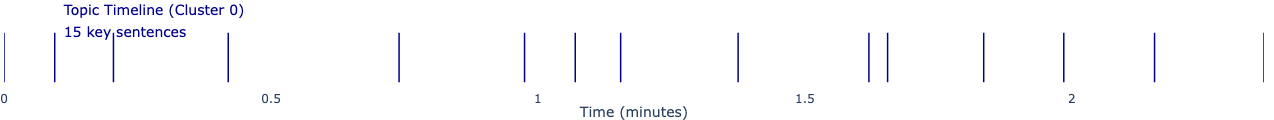

In [153]:
cluster_to_show = core.clusters[0].cluster_id
plot_topic_timeline(timeline, cluster_id=cluster_to_show, time_unit="min")

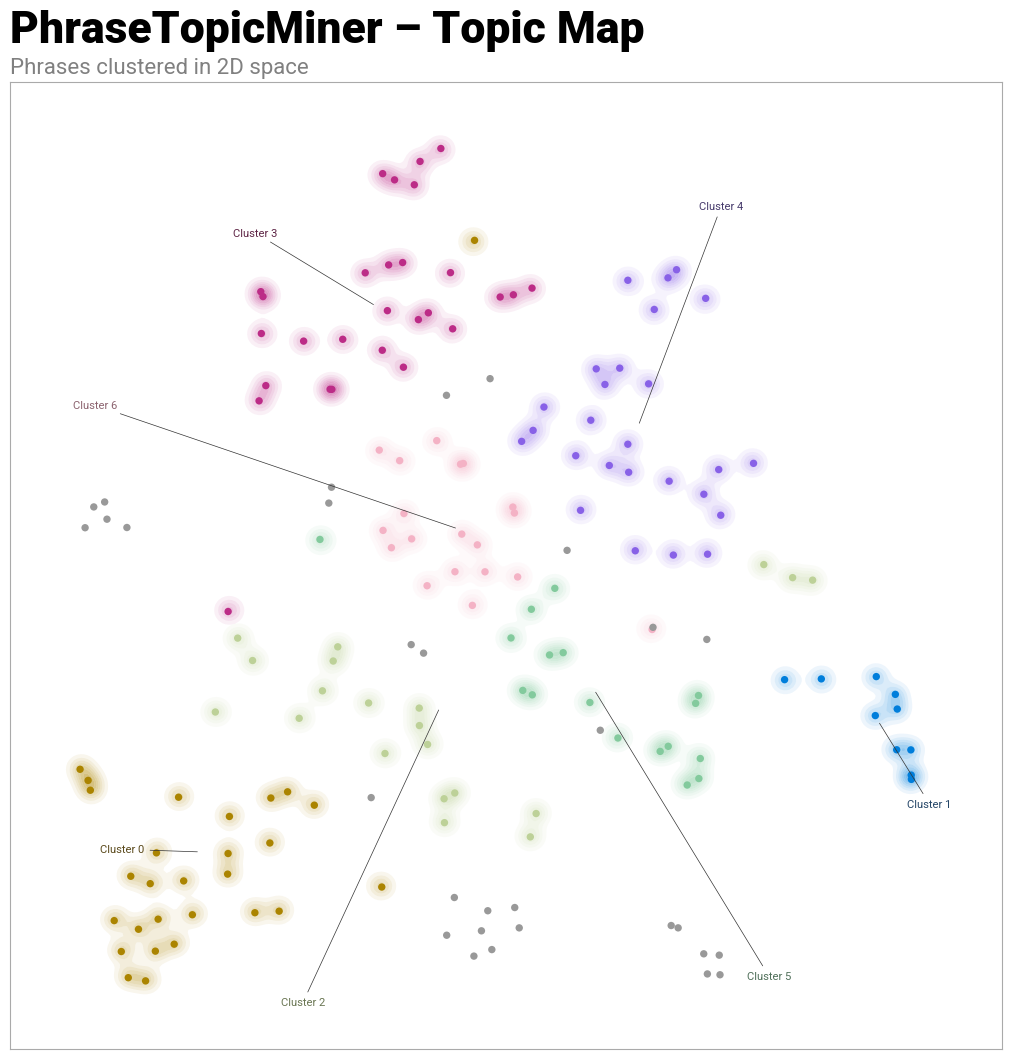

In [154]:
import numpy as np
import datamapplot

def make_datamapplot_from_topics(core_result, cluster_name_map=None):
    """
    core_result: TopicCoreResult from TopicModeler.fit_core
    cluster_name_map: optional {cluster_id: human_title} dict
                      (e.g. from an LLM labeling step)
    """
    df = core_result.phrases_df

    # 2D coordinates from TopicModeler (UMAP / t-SNE)
    data_map = df[["x", "y"]].to_numpy(dtype="float32")

    # Base labels: one label per point (phrase)
    cluster_ids = df["cluster_id"].to_numpy()

    # Optional human-readable topic names
    if cluster_name_map is None:
        # simple fallback: "Cluster 0", "Cluster 1", ...
        cluster_name_map = {
            cid: f"Cluster {cid}" for cid in np.unique(cluster_ids) if cid != -1
        }

    labels = []
    for cid in cluster_ids:
        if cid == -1:
            labels.append("Unlabelled")  # noise / no topic
        else:
            labels.append(cluster_name_map.get(cid, f"Cluster {cid}"))
    labels = np.asarray(labels, dtype=object)

    fig, ax = datamapplot.create_plot(
        data_map,
        labels,
        noise_label="Unlabelled",
        title="PhraseTopicMiner – Topic Map",
        sub_title="Phrases clustered in 2D space",
        # and any other tweaks you like:
        # label_font_size=11,
        # use_medoids=True,
        # label_wrap_width=8,
    )

    # Save or return for your UI
    fig.savefig("topic_map.png", bbox_inches="tight")
    return fig, ax

# usage:
# core = modeler.fit_core(...)
fig, ax = make_datamapplot_from_topics(core, cluster_name_map=None)


In [155]:
core.phrases_df

phrase  count  n_tokens  \
0                   phrase      4         1   
1         phrasetopicminer      4         1   
2                  phrases      3         1   
3                 concepts      2         1   
4                   topics      2         1   
..                     ...    ...       ...   
173            workarounds      1         1   
174               outcomes      1         1   
175    consistent language      1         2   
176      describe friction      1         2   
177  interprets texts line      1         3   

                                             embedding  cluster_id          x  \
0    [0.036300506, 0.081972726, 0.015533596, 0.0889...           0  -9.281878   
1    [-0.013518695, 0.011223617, -0.04242844, -0.03...           0  -7.704142   
2    [0.021204585, 0.06599245, 0.054480646, 0.08563...           0  -9.481070   
3    [0.04710838, -0.0049566072, -0.0761147, 0.0143...           5   6.970906   
4    [0.020447103, -0.005743391, -0.038933072, 0.01...           1  12.568277   
..                                                 ...         ...        ...   
173  [-0.09457863, 0.012882569, 0.044443123, 0.0171...           6  -1.552004   
174  [-0.016551042, 0.08920398, 0.02269189, 0.01507...           3  -1.443392   
175  [-0.02764051, -0.027190095, -0.00267245, -0.03...           0  -3.982480   
176  [-0.04457164, -0.017591098, 0.019274386, 0.032...           4   1.923350   
177  [-0.05352306, 0.0798091, -0.010439551, 0.00347...           2  -4.413674   

             y  
0   -12.042369  
1    -9.151951  
2   -11.261210  
3    -6.093545  
4    -3.579320  
..         ...  
173   3.402770  
174   6.193720  
175  -6.889726  
176   3.978738  
177  -4.293609  

[178 rows x 7 columns]

In [156]:
# import numpy as np
# import datamapplot
# from datamapplot import render_html
# from IPython.display import display
# from IPython.display import IFrame

# # Suppose from TopicModeler core:
# # phrases_df has columns ['phrase', 'x', 'y', 'cluster_id']
# phrases_df = core.phrases_df

# # 1) Coordinates: use the 2D viz embedding from TopicModeler (x, y)
# coords = phrases_df[["x", "y"]].to_numpy()  # shape (n_phrases, 2)

# # Unique cluster IDs
# cluster_ids = sorted(phrases_df["cluster_id"].unique().tolist())

# # 2) Labels: cluster IDs as strings; mark noise as "Unlabelled"
# raw_labels = phrases_df["cluster_id"].to_numpy()
# labels = raw_labels.astype(str)
# # Turn numeric cluster IDs into human-readable string labels
# labels_str = np.where(
#     cluster_ids == -1,
#     "Unlabelled",                                # noise points
#     [f"Cluster {cid}" for cid in cluster_ids],   # regular clusters
# )
# labels[raw_labels == -1] = "Unlabelled"

# # 3) Hover text: whatever you like
# hover_text = [
#     f"{phrase} \n(count={count}, cluster={cid})"
#     for phrase, count, cid in zip(
#         phrases_df["phrase"],
#         phrases_df["count"],
#         phrases_df["cluster_id"],
#     )
# ]

# # 4) Build interactive plot
# fig = datamapplot.create_interactive_plot(
#     coords,
#     labels_str,                         # first (and only) label layer
#     hover_text=hover_text,          # optional
#     noise_label="Unlabelled",       # must match the string used for noise
#     title="PhraseTopicMiner – Interactive Topic Map",
# )

# # 5) In Jupyter: display inline
# display(fig)

# # 6) Save to HTML (fully interactive)
# fig.save("phrase_topics.html")
# # display(IFrame("phrase_topics.html", width=1000, height=800))


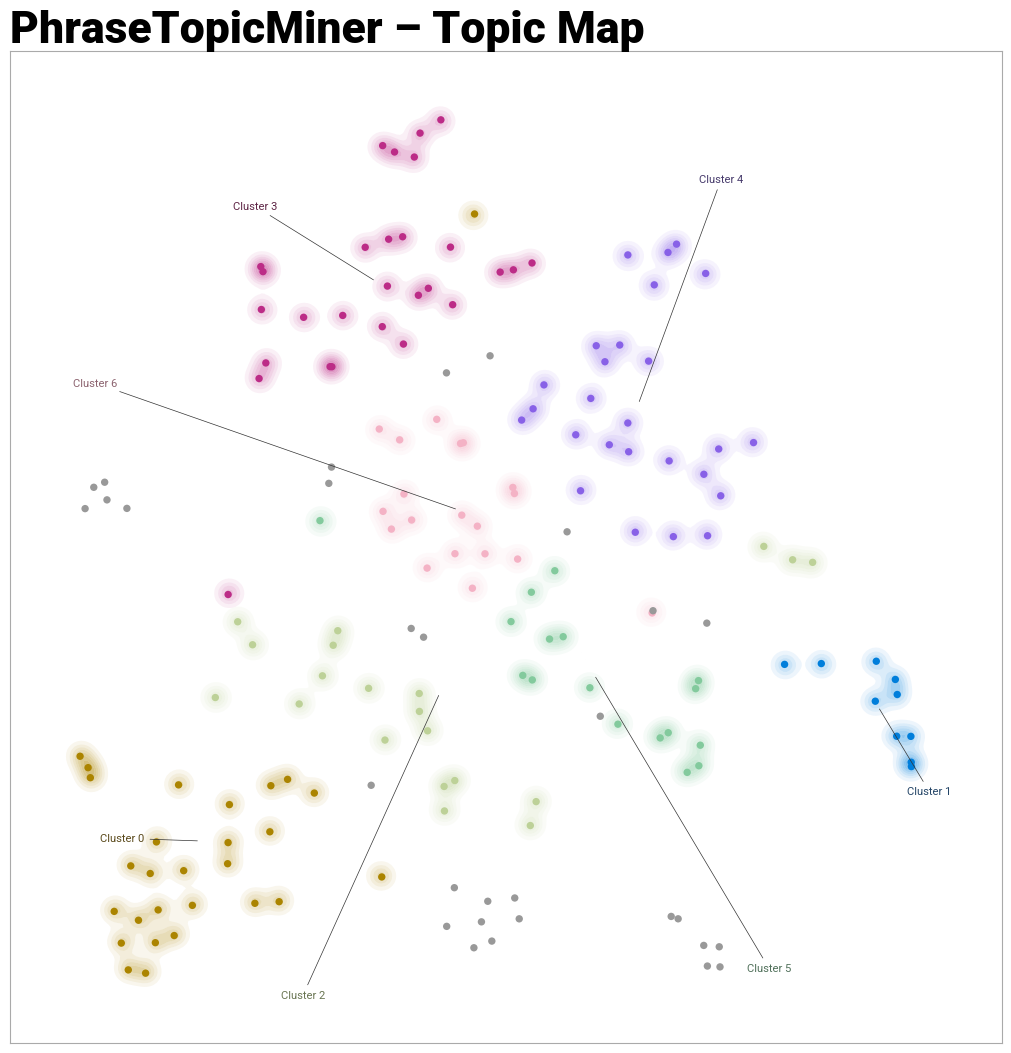

In [157]:
import numpy as np
import datamapplot
import matplotlib.pyplot as plt

phrases_df = core.phrases_df

coords = phrases_df[["x", "y"]].to_numpy()
cluster_ids = phrases_df["cluster_id"].to_numpy()  # ints, may include -1 for noise

# Turn numeric cluster IDs into human-readable string labels
labels_str = np.where(
    cluster_ids == -1,
    "Unlabelled",                                # noise points
    [f"Cluster {cid}" for cid in cluster_ids],   # regular clusters
)

fig, ax = datamapplot.create_plot(
    coords,
    labels_str,
    noise_label="Unlabelled",                    # must match the string above
    title="PhraseTopicMiner – Topic Map",
)

plt.show()


In [158]:
# # For DataMapPlot:
# dm_df = make_datamapplot_dataframe(core)
# dm_df.to_csv("phrases_for_datamapplot.csv", index=False)

In [159]:
# dm_df

Calculating medoids: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1340.77it/s]


<InteractiveFigure width=100% height=800>
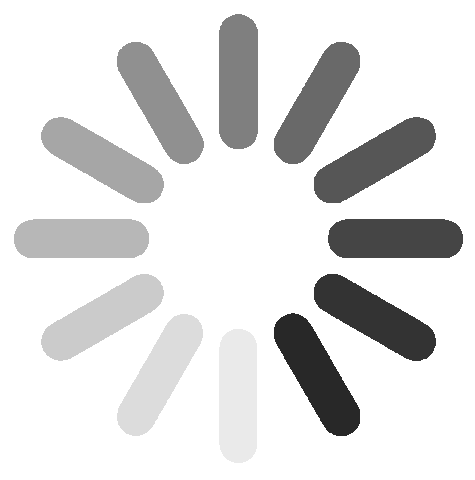

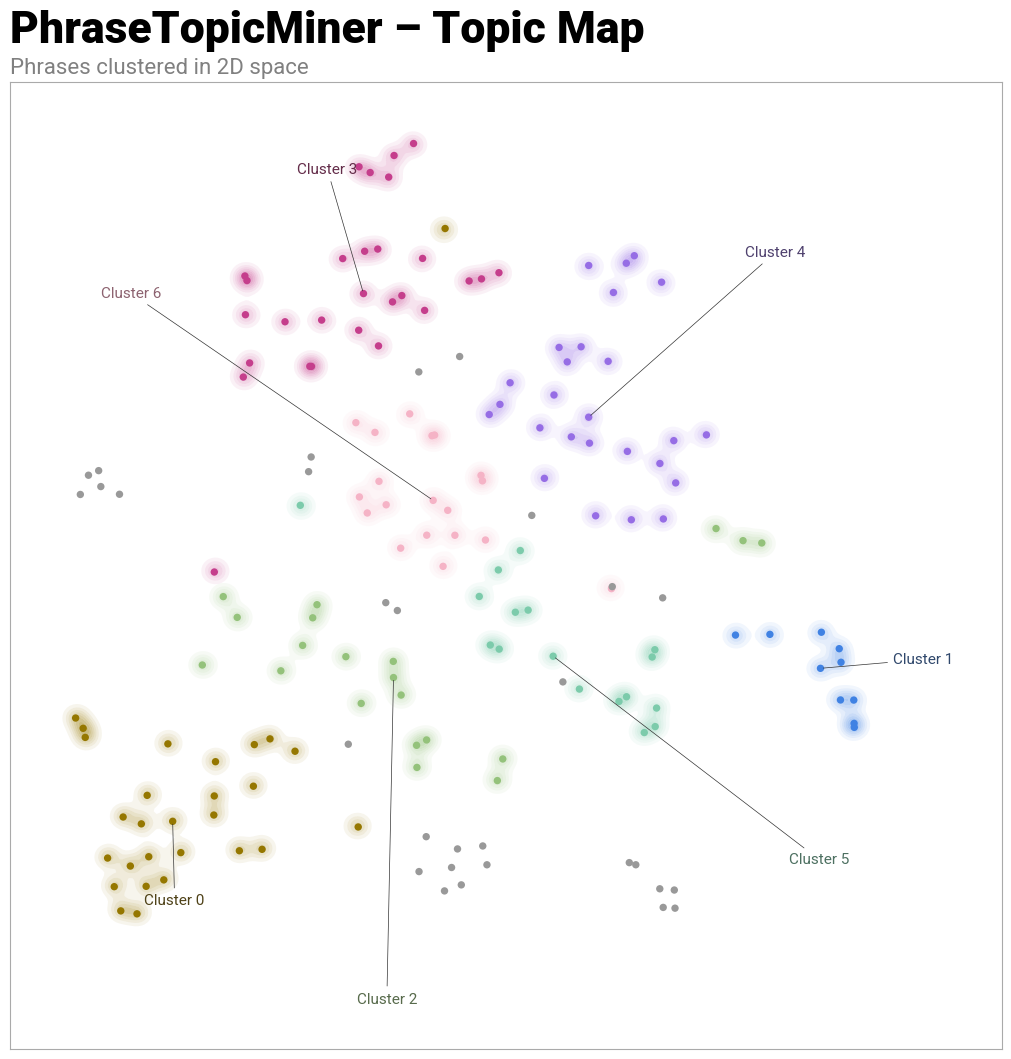

In [160]:
from phrasetopicminer.visualization_datamap import (
    make_datamapplot_static,
    make_datamapplot_interactive,
    build_phrase_sentence_examples_from_occurrences
)


# Build phrase → sentence examples
phrase_sentence_examples = build_phrase_sentence_examples_from_occurrences(
    core,
    sentences_by_doc,
    max_sentences_per_phrase=1,
    min_sentence_chars=30,
)


# (Optionally) LLM topic titles:
cluster_name_map = {
    0: "test titel 1",
    1: "test title 2",
    # ...
}

# Static PNG:
fig, ax = make_datamapplot_static(
    core,
    # cluster_name_map=cluster_name_map,
    save_path="topic_map.png",
    label_font_size=11,
    use_medoids=True,
)

# Interactive topic map with highlighted sentences in the hover
# fig_int = make_datamapplot_interactive(
#     core,
#     phrase_sentence_examples=phrase_sentence_examples,
#     cluster_name_map=cluster_name_map,
#     point_size=8.0,            # our convenience arg → marker_size_array
#     height=800,
#     width="100%",
#     use_medoids=True,
#     enable_topic_tree=False,   # or True, up to you
# )

fig_int = make_datamapplot_interactive(
    core,
    sentences_by_doc=sentences_by_doc,
    cluster_name_map=cluster_name_map,
    point_size=5,  
    save_html_path="phrase_topics.html",
)

# In Jupyter: `display(fig_int)`
display(fig_int)


In [163]:
from phrasetopicminer.topic_labeler import TopicLabeler, TopicLabelModel, TopicLabelingResult


from agents import Agent
# core: TopicCoreResult from TopicModeler.fit_core(...)
# sentences_by_doc: List[List[str]] from PhraseMiner.mine_phrases_with_types(...)

topic_agent = Agent(
    name="PhraseTopicLabeler",
    instructions=(
        "You are a topic labeling assistant. "
        "Given key phrases and example sentences for a single topic, "
        "you must respond ONLY with JSON containing 'title' and "
        "'description'."
    ),
)

labeler = TopicLabeler(
    topic_agent,
    max_phrases_per_cluster=25,
    max_sentences_per_cluster=40,
    include_noise=False,
)

# import asyncio

# Cell is allowed to use `await` in Jupyter
labeling_result = await labeler.label_topics_async(core, sentences_by_doc)

cluster_name_map = labeling_result.cluster_name_map





Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.
Trace already exists. Creating a new trace, but this is probably a mistake.


[TopicLabeler] Found cluster_ids in core_result: [-1, 0, 1, 2, 3, 4, 5, 6]
[TopicLabeler] Labeling 7 cluster(s): [0, 1, 2, 3, 4, 5, 6]
[TopicLabeler] Prepared cluster inputs (phrases + sentences) for 7 cluster(s).
[TopicLabeler] Calling agent for cluster 0...
[TopicLabeler] Calling agent for cluster 1...
[TopicLabeler] Calling agent for cluster 2...
[TopicLabeler] Calling agent for cluster 3...
[TopicLabeler] Calling agent for cluster 4...
[TopicLabeler] Calling agent for cluster 5...
[TopicLabeler] Calling agent for cluster 6...
[TopicLabeler] Agent output for cluster 1: {
  "title": "Phrase-Based Topic Modeling",
  "description": "This topic focuses on analyzing text by mining and groupin...
[TopicLabeler] Agent output for cluster 5: {
  "title": "Mapping Conceptual Structures and Change",
  "description": "This topic explores tools and methods for vis...
[TopicLabeler] Agent output for cluster 2: {
  "title": "Analyzing Intellectual Trends in Texts",
  "description": "This topic exa

In [164]:
# 2) Full audit trail per cluster:
for lc in labeling_result.labeled_clusters:
    print(lc.cluster_id, lc.label.title)
    print(" ", lc.label.description)
    print("Rep phrases:", lc.phrases_with_counts)
    print("Example sentence:", lc.example_sentences if lc.example_sentences else "-")
    print("Importance:", lc.importance_score, "Rank:", lc.rank)
    print()
    print()

# 3) Config for logging:
print(labeling_result.config["topic_modeler_config"])
print(labeling_result.config["labeler_name"])

0 Phrase-Based Topic Modeling
  This topic centers on identifying, mining, and clustering meaningful multi-word phrases within text collections to surface coherent themes and conceptual patterns. Unlike traditional models that focus on single words, the approach extracts noun and verb phrases as key carriers of meaning, enhancing interpretability and relevance. Tools such as PhraseTopicMiner enable tracking these phrase clusters over time, revealing the evolution of ideas and recurring expressions in various types of documents, such as transcripts and historical texts.
Rep phrases: [('phrase', 4), ('phrasetopicminer', 4), ('phrases', 3), ('phrase clusters', 2), ('Phrase', 1), ('recurring expressions', 1), ('extracting phrases', 1), ('phrases reveals', 1), ('abstract word distributions', 1), ('readable expressions', 1), ('mine phrases', 1), ('main carriers of meaning in a document collection', 1), ('verb phrases', 1), ('mine key phrases', 1), ('key phrases from the transcripts', 1), ('m

In [165]:
lc

LabeledTopicCluster(cluster_id=1, label=TopicLabelModel(title='Phrase-Based Topic Modeling', description='This topic focuses on analyzing text by mining and grouping meaningful phrases, rather than individual words, to identify coherent themes in documents. By clustering key phrases from various sources like articles or forum posts, phrase-centric topic models create interpretable maps of concepts and discussions. This approach enhances topic discovery and conceptual tracking in collections such as educational materials or historical texts.'), phrases_with_counts=[('topics', 2), ('centric topic model', 2), ('topics provides', 1), ('newspaper articles', 1), ('based topic modeling treats noun phrases', 1), ('neural topic model', 1), ('topic', 1), ('topic is anchored', 1), ('discussion forum posts', 1), ('topic modeling treats noun phrases', 1)], representative_phrases=['topics', 'centric topic model', 'topics provides', 'topic modeling treats noun phrases', 'neural topic model', 'based t

Calculating medoids: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 639.93it/s]


<InteractiveFigure width=100% height=800>
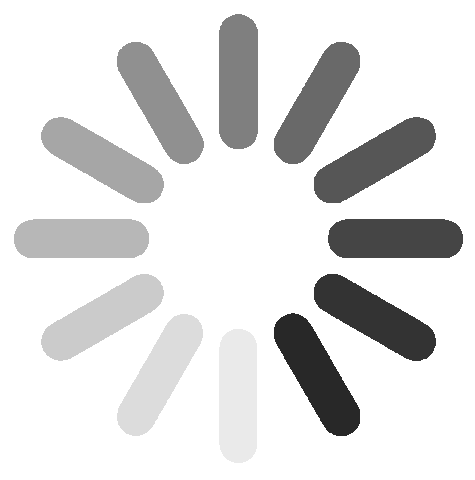

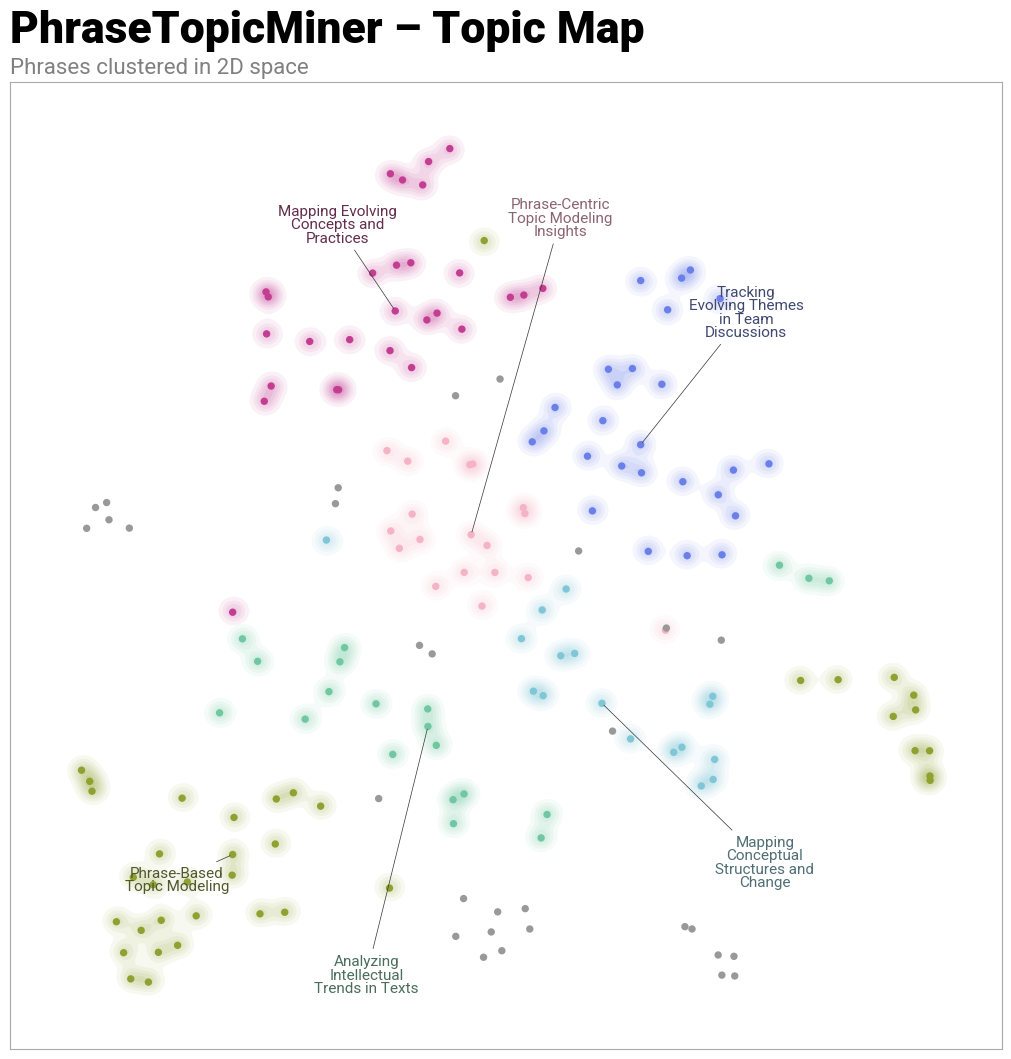

In [166]:



# → plug this straight into your DataMapPlot helper:


# Static PNG:
fig, ax = make_datamapplot_static(
    core,
    cluster_name_map=cluster_name_map,
    save_path="topic_map.png",
    label_font_size=11,
    use_medoids=True,
)

# Interactive topic map with highlighted sentences in the hover
fig_int = make_datamapplot_interactive(
    core,
    sentences_by_doc=sentences_by_doc,
    cluster_name_map=cluster_name_map,
    point_size=5,  
    save_html_path="phrase_topics.html",
)

# In Jupyter: `display(fig_int)`
display(fig_int)


In [167]:
cluster_name_map


{0: 'Phrase-Based Topic Modeling',
 1: 'Phrase-Based Topic Modeling',
 2: 'Analyzing Intellectual Trends in Texts',
 3: 'Mapping Evolving Concepts and Practices',
 4: 'Tracking Evolving Themes in Team Discussions',
 5: 'Mapping Conceptual Structures and Change',
 6: 'Phrase-Centric Topic Modeling Insights'}

In [49]:
sentences_by_doc

[['Aspects of the mind\nThought is when we absorb what happens around us so that we can deal with it effectively according to our plans and desires.',
  'Thinking is using information, like forming concepts, problem solving, reasoning and making choices.',
  'Memory is when we store information in our minds, and can later recall it.',
  'Imagination is the \nability to invent worlds inside the mind\n, complete or not.',
  'The mind makes these by \ndrawing on experience in the shared world\n.',
  'Consciousness is knowing that we exist and the world exists, and being able to understand what happens around us.',
  'Mental health\nJust like the body, a mind can be healthy.',
  'The measure of this is called mental health.',
  'According to the World Health Organization (WHO), there is not one way to measure mental health in all people, because there are many things in our environment that might make what is mentally healthy different from one person to another.',
  'In general, most expe

In [55]:
phrase_records[0]

PhraseRecord(phrase='aspects of the mind', surface='Aspects of the mind', kind='NP', pattern='NP+PP', doc_index=0, sent_index=0)

In [57]:
main_clusters = [c for c in core.clusters if c.cluster_id != -1]
noise_cluster = [c for c in core.clusters if c.cluster_id == -1]
print(noise_cluster)
main_clusters[0]

[TopicCluster(cluster_id=-1, phrases=['red spot on a wall', 'physical wall', 'responds to the colour', 'depending on the physical wall', 'drawing on experience', 'making choices', 'according to the World Health Organization'], phrase_counts=[1, 1, 1, 1, 1, 1, 1], total_count=7, representative_phrases=['physical wall', 'depending on the physical wall', 'drawing on experience', 'red spot on a wall', 'responds to the colour', 'making choices', 'according to the World Health Organization'], importance_score=14.55609079175885)]


TopicCluster(cluster_id=4, phrases=['mind', 'think that the mind', 'think that everything', 'belief that mind', 'aspects of the mind', 'brain responds', 'believe that the mind', 'mind makes', 'consciousness is knowing', 'worlds inside the mind', 'thinking is using', 'philosophy of mind', 'nature of the mind', 'questions about the nature of the mind', 'mind is related'], phrase_counts=[8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], total_count=22, representative_phrases=['mind', 'nature of the mind', 'belief that mind', 'think that the mind', 'philosophy of mind', 'believe that the mind', 'mind is related', 'mind makes', 'questions about the nature of the mind', 'aspects of the mind'], importance_score=60.99695188927519)

In [62]:
for i in range(len(labeling_result.labels_by_cluster)):
    print(labeling_result.labels_by_cluster[i].title)
    print(main_clusters[-i-1].representative_phrases)
    print(labeling_result.labels_by_cluster[i].description)
    print("")


Coping With Life's Challenges
['solve problems', 'problem solving', 'difficult situations', 'problems of everyday life', 'main problem', 'recover from difficult situations']
This topic explores the ways individuals address and overcome challenges in daily life, including various methods of problem solving and recovery from adversity. It covers the psychological aspects of managing stress, making decisions, and handling difficult situations to maintain mental health and independence.

Philosophy of Mind and Monism
['body', 'related to the body', 'relation to the physical body', 'linked to the body', 'body problem', 'two parts of a larger being', 'are two parts']
This topic explores major philosophical perspectives on the relationship between mind and body, such as idealism, physicalism, and monism. It examines historical and contemporary views from Western and Eastern traditions, including contributions by figures like Descartes and Spinoza. The discussion includes the evolution of thes

In [43]:
labeling_result.labels_by_cluster[0]

TopicLabelModel(title="Coping With Life's Challenges", description='This topic explores the ways individuals address and overcome challenges in daily life, including various methods of problem solving and recovery from adversity. It covers the psychological aspects of managing stress, making decisions, and handling difficult situations to maintain mental health and independence.')

In [ ]:
from collections import Counter
# atext = """
# 1. Aspects of the mind
# Thought is when we absorb what happens around us so that we can deal with it effectively according to our plans and desires. Thinking is using information, like forming concepts, problem solving, reasoning and making choices.

# Memory is when we store information in our minds, and can later recall it.

# Imagination is the **ability to invent worlds inside the mind**, complete or not. The mind makes these by *drawing on experience in the shared world*.

# Consciousness is knowing that we exist and the world exists, and being able to understand what happens around us.

# 2. Mental health
# Just like the body, a mind can be healthy. The measure of this is called mental health. According to the World Health Organization (WHO), there is not one way to measure mental health in all people, because there are many things in our environment that might make what is mentally healthy different from one person to another. In general, most experts agree that "mental health" and "mental illness" are not opposites. In other words, not having a mental illness does not mean you are in good mental health.

# Kant was thinking about the limitations of reason.
# """
texts = [text]  # or list of documents

# # 1) Phrase mining
# miner = PhraseMiner(
#     method="spacy",
#     spacy_model="en_core_web_lg",
#     include_verb_phrases=True,
#     clean_markdown=True,
# )

# np_counter, vp_counters, phrase_records, sentences_by_doc = miner.mine_phrases_with_types([text])

# Sorted noun phrases
sorted_nps = np_counter.most_common()

# Sorted VerbObj patterns
sorted_verbobj = vp_counters.get("VerbObj", Counter()).most_common()

# Sorted SubjVerb patterns (if you keep them)
sorted_subjverb = vp_counters.get("SubjVerb", Counter()).most_common()

# Sorted SubjCopula patterns (if you keep them)
sorted_subjcopula = vp_counters.get("SubjCopula", Counter()).most_common()

In [ ]:
vp_counters

In [ ]:
sorted_subjcopula

In [ ]:
p_sent_1 = [r.phrase for r in phrase_records if r.sent_index == 1]
p_sent_1

In [50]:
phrase_records[:5]

[PhraseRecord(phrase='aspects of the mind', surface='Aspects of the mind', kind='NP', pattern='NP+PP', doc_index=0, sent_index=0),
 PhraseRecord(phrase='thought', surface='Thought', kind='NP', pattern='BaseNP', doc_index=0, sent_index=0),
 PhraseRecord(phrase='plans', surface='plans', kind='NP', pattern='BaseNP', doc_index=0, sent_index=0),
 PhraseRecord(phrase='desires', surface='desires', kind='NP', pattern='BaseNP', doc_index=0, sent_index=0),
 PhraseRecord(phrase='thought is', surface='Thought is', kind='VP', pattern='SubjCopula', doc_index=0, sent_index=0)]

In [ ]:
# from collections import Counter

# texts = [text]  # or list of documents

# # 1) Phrase mining
# miner = PhraseMiner(
#     method="spacy", 
#     spacy_model="en_core_web_lg", 
#     include_verb_phrases=True,        
#     clean_markdown=True
# )

# np_counter, vp_counters, meta = miner.mine_phrases_with_types(
#     [text],
#     include_metadata=True,
# )

# # Sorted noun phrases
# sorted_nps = np_counter.most_common()

# # Sorted VerbObj patterns
# sorted_verbobj = vp_counters.get("VerbObj", Counter()).most_common()

# # Sorted SubjVerb patterns (if you keep them)
# sorted_subjverb = vp_counters.get("SubjVerb", Counter()).most_common()



In [ ]:
# # 2) Topic modeling
# modeler = TopicModeler(
#     embedding_backend="sentence_transformers", # Literal["sentence_transformers", "spacy", "custom"]
#     embedding_model="all-MiniLM-L6-v2",
#     embedding_fn=None,
#     spacy_nlp=None,
#     random_state=42,
# )

In [ ]:

# 2) Topic modeling (core clustering API)
modeler = TopicModeler(
    embedding_backend="sentence_transformers",   # or "spacy", "openai", "cohere", "custom"
    embedding_model="all-MiniLM-L6-v2",
    embedding_fn=None,    # only if embedding_backend="custom"
    spacy_nlp=None,       # only if embedding_backend="spacy"
    random_state=42,
)

topic_core_result = modeler.fit_core(
    # --- required core inputs ---
    phrase_records=phrase_records,
    sentences_by_doc=sentences_by_doc,

    # --- phrase filtering options ---
    include_kinds={"NP"},          # only NP; use {"NP", "VP"} to include both
    include_patterns={"BaseNP", "NP+PP", "NP+multiPP", 
                    #   "VerbObj", "VerbPP", "SubjVerb"
                      },  # or e.g. {"BaseNP", "NP+PP"}
    min_freq_unigram=2,            # threshold for 1-word phrases
    min_freq_bigram=1,             # threshold for 2-word phrases
    min_freq_trigram_plus=1,       # threshold for >=3-word phrases

    # --- geometric pipeline options ---
    pca_n_components=10,           # 0 or None if you want to skip PCA
    cluster_geometry="umap_nd",    # "umap_nd" or "umap_2d"
    umap_n_neighbors=5,
    umap_min_dist=0.1,
    umap_cluster_n_components=10,  # target dim for clustering (if using umap_nd)

    # --- clustering options ---
    clustering_algorithm="kmeans",   # "hdbscan" or "kmeans"
    hdbscan_min_cluster_size=3,
    hdbscan_min_samples=None,
    hdbscan_metric="euclidean",
    kmeans_max_clusters=15,          # used only if clustering_algorithm="kmeans"

    # --- visualization geometry ---
    viz_reducer="umap_2d",           # "same", "umap_2d", or "tsne_2d"
    tsne_perplexity=30.0,
    tsne_learning_rate=200.0,
    tsne_n_iter=1000,

    # --- cluster representatives ---
    top_n_representatives=20,

    verbose=True,
)

In [53]:
# topic_core_result

In [54]:
topic_core_result.phrases_df

NameError: name 'topic_core_result' is not defined

In [ ]:


main_clusters = [c for c in topic_core_result.clusters if c.cluster_id != -1]
noise_cluster = [c for c in topic_core_result.clusters if c.cluster_id == -1]
print(noise_cluster)
main_clusters


In [ ]:
for i in range(len(topic_core_result.clusters)):
    print(len(topic_core_result.clusters[i].phrases))
    print(len(topic_core_result.clusters[i].representative_phrases))
    print(topic_core_result.clusters[i].importance_score)

    

In [ ]:
for p in topic_core_result.clusters[0].phrases:
    print(p)
    print(topic_core_result.phrase_sentences[p])


In [ ]:
topic_core_result.phrase_occurrences["mental health"]

In [ ]:
topic_core_result.phrase_sentences["mental health"]

In [ ]:
topic_core_result.config

In [ ]:
from collections import Counter

texts = [text]  # or list of documents

# 1) Phrase mining
miner = PhraseMiner(
    method="spacy", 
    spacy_model="en_core_web_lg", 
    include_verb_phrases=True,        
    clean_markdown=True
)

phrase_counts: Counter = miner.mine_phrases(texts)

# 2) Topic modeling (core API – clustering only)
modeler = TopicModeler(
    clusterer="hdbscan",  # or "kmeans"
    min_freq_unigram=1,
    min_freq_bigram=1,
    min_freq_trigram_plus=1,
)

result = modeler.fit(
    phrase_counts=phrase_counts,
    original_texts=texts,
    # optional per-call overrides:
    hdbscan_min_cluster_size=3,
    kmeans_max_clusters=15,
)

# `result` is a TopicClusteringResult
for cluster in result.clusters:
    print("\nCluster", cluster.cluster_id)
    print("Representative phrases:", cluster.representative_phrases)
    print("Representative sentences:", cluster.representative_sentences)


In [ ]:
phrase_counts

In [ ]:
np_counter, vp_counters, meta = miner.mine_phrases_with_types(
    [text],
    include_metadata=True,
)

# Sorted noun phrases
sorted_nps = np_counter.most_common()

# Sorted VerbObj patterns
sorted_verbobj = vp_counters.get("VerbObj", Counter()).most_common()

# Sorted SubjVerb patterns (if you keep them)
sorted_subjverb = vp_counters.get("SubjVerb", Counter()).most_common()


In [ ]:
sorted_nps

In [ ]:
sorted_verbobj

In [ ]:
sorted_subjverb

In [ ]:
for record in meta:
    print(f"{record.surface}: {record.pattern}")
    print('')

In [ ]:
text1 = """
Psychology
Psychology is the study of the way we think, feel and act. It involves the scientific study of processes such as perception, cognition, feelings, personality, as well as things around us that might affect the way we think. From this study, psychologists try to form rules for why we act the way we do. Psychology also includes using this knowledge to help solve problems of everyday life and treat mental health problems.
"""


texts = [text1]

# 1) Phrase mining
nltk_miner = PhraseMiner(
    method="spacy", 
    spacy_model="en_core_web_lg", 
    include_verb_phrases=True,        
    clean_markdown=True
)

nltk_phrase_counts = nltk_miner.mine_phrases(texts)
nltk_phrase_counts

In [ ]:
total_np, total_vp, metadata = nltk_miner.mine_phrases_with_types(texts, include_metadata=True)

In [ ]:
total_np

In [ ]:
total_vp

In [ ]:
metadata

In [ ]:
for record in metadata:
    print(f"{record.surface}: {record.pattern}")
    print('')

# PhraseMiner

In [ ]:
import re
from collections import Counter
from typing import Dict, Iterable, List, Sequence, Tuple


class PhraseMiner:
    """
    A modular class for extracting noun phrases (NPs) and optional verb-argument patterns (VAPs) using grammar-based approaches.
    
    Parameters
    ----------
    method:
        Either ``"spacy"`` (default) or ``"nltk"`` – determines the underlying
        tokenizer + tagger.  SpaCy gives better accuracy; NLTK keeps the wheel‑size
        small when users cannot install binary wheels.
    spacy_model:
        Only used when ``method='spacy'``.  Defaults to *en_core_web_sm*.
    include_verb_phrases:
        If ``True`` the :py.meth:`mine_phrases` output will also include verb‑argument
        patterns (*Verb–Object*, *Verb–PP*, *Subject–Verb*) with counts.
    """

    # -------------------------
    # Construction helpers
    # -------------------------
    def __init__(
        self,
        method: str = "spacy",
        spacy_model: str = "en_core_web_sm",
        include_verb_phrases: bool = False,
    ) -> None:
        self.method = method.lower()
        self.spacy_model = spacy_model
        self.include_verb_phrases = include_verb_phrases

        if self.method == "spacy":
            self._nlp = self._load_spacy_model(spacy_model)
        elif self.method == "nltk":
            self._tokenizer, self._tagger = self._load_nltk_models()
        else:
            raise ValueError("method must be 'spacy' or 'nltk'")

        # Coarse POS map for phrase grammar
        self.coarsemap = {
            "A": ["JJ", "JJR", "JJS", "ADJ", "CD", "A", "CoarseADJ", "CoarseNUM"],          # Adjectives
            "D": ["DT", "DET", "D", "CoarseDET"],                                           # Determiners
            "P": ["IN", "TO", "ADP", "P", "CoarseADP"],                                     # Prepositions
            "N": ["NN", "NNS", "NNP", "NNPS", "FW", "NOUN", "PROPN", "N", "CoarseNOUN"],    # Nouns
            "V": ["VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],                                 # Verbs
            "O": []                                                                         # Other tags
        }

        # Noun Phrase Grammars
        self.base_np_grammar = r"(A|N)*N"  # BaseNP: (Adj | Noun)* Noun
        self.pp_grammar = r"P(D*(A|N)*N)"  # PP: Preposition Determiner* BaseNP
        self.np_grammar = rf"{self.base_np_grammar}({self.pp_grammar})*"  # NP: BaseNP PP*

        # Verb-Argument Patterns
        self.verb_arg_grammar = {
            "VerbObj": r"V(N|A)*N",  # Verb-Obj: Verb followed by (Adj)* Noun
            "VerbPP": r"V(PD*(A|N)*N)",  # Verb-PP: Verb followed by Prepositional Phrase
            "SubjVerb": r"N(V)+",  # Subj-Verb: Noun followed by Verb (minimum 1 verb required)
        }

    # -------------------------
    # Public API
    # -------------------------
    def mine_phrases(self, texts: List[str]) -> Counter:
        """
        Main method to extract phrases from a list of texts, and then
        remove 'subsumed' (overlapping) phrases by adjusting frequencies.

        Args:
            texts (List[str]): A list of strings (documents).

        Returns:
            Counter: A frequency distribution of cleaned phrases.
        """
        # Step 1: Extract phrases from all docs
        phrase_counter = Counter()
        for doc in texts:
            tokens, pos_tags = self._tag_text(doc)
            # Noun Phrases
            np_counts = self._extract_noun_phrases(tokens, pos_tags)
            phrase_counter.update(np_counts)

            # Verb Phrases (optional)
            if self.include_verb_phrases:
                vp_counts_dict = self._extract_verb_phrases(tokens, pos_tags)
                for pattern_counts in vp_counts_dict.values():
                    phrase_counter.update(pattern_counts)

        # Step 2: Remove subsumed phrases (token-based sublist logic)
        cleaned_phrases = self._remove_subsumed_phrases(phrase_counter)

        return cleaned_phrases

    # -------------------------
    # Internal Tagging Methods
    # -------------------------
    def _tag_text(self, text: str):
        """
        Return *merged* tokens and POS tags.
        Possessive endings ( ’s / 's / ’ ) are glued to the preceding noun
        so “Kant’s moral philosophy” is treated as one noun‑phrase.
        """
        if self.method == "spacy":
            doc = self._nlp(text)
            tokens = [token.text for token in doc]
            pos_fine = [token.tag_ for token in doc]  # Fine-grained tags
        else:
            # NLTK approach
            import nltk
            tokens = nltk.word_tokenize(text)
            pos_fine = [t for _, t in self.tagger.tag(tokens)]
            tokens = [w for w, _ in self.tagger.tag(tokens)]
            
        tokens, pos_fine = self._merge_possessives(tokens, pos_fine)
        return tokens, pos_fine

    # -------------------------
    # Phrase Extraction Methods
    # -------------------------
    def _extract_noun_phrases(self, tokens: List[str], pos_tags: List[str]) -> Counter:
        coarse_tags = self._to_coarse_tags(pos_tags)
        tag_sequence = ''.join(coarse_tags)

        # Match noun phrases with the NP grammar
        matches = re.finditer(self.np_grammar, tag_sequence)
        phrases = [
            ' '.join(tokens[m.start():m.end()]).lower()
            for m in matches
        ]
        return Counter(phrases)

    def _extract_verb_phrases(self, tokens: List[str], pos_tags: List[str]) -> Dict[str, Counter]:
        patterns = {}
        coarse_tags = self._to_coarse_tags(pos_tags)
        tag_sequence = ''.join(coarse_tags)

        for name, grammar in self.verb_arg_grammar.items():
            matches = re.finditer(grammar, tag_sequence)
            phrases = [
                ' '.join(tokens[m.start():m.end()]).lower()
                for m in matches
            ]
            patterns[name] = Counter(phrases)
        return patterns

    # ------------------
    # Utility • Tag maps
    # ------------------
    def _to_coarse_tags(self, pos_tags: List[str]) -> List[str]:
        """Convert fine-grained tags to coarse categories."""
        return [self._map_tag(tag) for tag in pos_tags]

    def _map_tag(self, tag: str) -> str:
        for coarse, tag_list in self.coarsemap.items():
            if tag in tag_list:
                return coarse
        return 'O'

    # -------------------------------
    # Subsumed-Phrase Removal Method
    # -------------------------------
    def _remove_subsumed_phrases(self, phrase_counter: Counter) -> Counter:
        """
        If shorter_phrase is a contiguous sublist of a longer_phrase,
        reduce the shorter_phrase's frequency by the longer_phrase's frequency.
        Remove if freq <= 0.
        """
        phrases = phrase_counter.copy()
        # Sort by descending token length
        sorted_phrases = sorted(phrases.keys(), key=lambda x: len(x.split()), reverse=True)

        for i in range(len(sorted_phrases)):
            if sorted_phrases[i] not in phrases:
                continue
            longer_phrase = sorted_phrases[i]
            longer_freq = phrases[longer_phrase]
            if longer_freq <= 0:
                continue
            # Tokenize once
            longer_tokens = longer_phrase.split()

            # Check shorter phrases
            for j in range(i+1, len(sorted_phrases)):
                if sorted_phrases[j] not in phrases:
                    continue

                shorter_phrase = sorted_phrases[j]
                shorter_freq = phrases[shorter_phrase]
                if shorter_freq <= 0:
                    continue

                # Check token-based sublist
                if self._is_token_sublist(shorter_phrase, longer_tokens):
                    new_freq = shorter_freq - longer_freq
                    if new_freq <= 0:
                        del phrases[shorter_phrase]
                    else:
                        phrases[shorter_phrase] = new_freq

        # Remove anything that ended up <= 0
        return Counter({p: c for p, c in phrases.items() if c > 0})

    @staticmethod
    def _is_token_sublist(shorter_phrase: str, longer_tokens: List[str]) -> bool:
        """
        Return True if 'shorter_phrase' is a contiguous token sublist of 'longer_tokens'.
        Example:
            shorter_phrase = "university of california"
            longer_tokens = ["university", "of", "california", "berkeley"] -> True
        """
        shorter_tokens = shorter_phrase.split()
        len_shorter = len(shorter_tokens)
        len_longer = len(longer_tokens)
        if len_shorter == 0 or len_shorter > len_longer:
            return False

        for start_idx in range(len_longer - len_shorter + 1):
            if longer_tokens[start_idx : start_idx + len_shorter] == shorter_tokens:
                return True
        return False

    # ------------------
    # POS possessive merge
    # ------------------
    @staticmethod
    def _merge_possessives(tokens: List[str], tags: List[str]):
        """
        Merge [NOUN, POS] or [NOUN, '’'] into a single possessive‑noun token.
        * Do NOT merge when the first token is a pronoun (PRP, PRP$).
        * Works for both 's and trailing apostrophe (plural possessive).
        """
        merged_tok, merged_tag = [], []
        i = 0
        while i < len(tokens):
            if (i + 1 < len(tokens)
                and tags[i+1] == "POS"                         # SpaCy & NLTK use POS for ’s
                and tags[i] not in {"PRP", "PRP$"}             # skip he’s / she’s
                and tags[i] not in {"WP", "WP$"}):             # skip who’s etc.
                # combine tokens[i] + tokens[i+1]  ➜ keep noun tag
                merged_tok.append(tokens[i] + tokens[i+1])    # Kant + 's  →  Kant's
                merged_tag.append(tags[i])                    # keep original noun tag
                i += 2
            # plural possessive: token endswith 's'  +  next token is "'"
            elif (i + 1 < len(tokens)
                  and tokens[i+1] in {"'", "’"}
                  and tags[i] not in {"PRP", "PRP$", "WP", "WP$"}):
                merged_tok.append(tokens[i] + tokens[i+1])    # philosophers + ' → philosophers'
                merged_tag.append(tags[i])
                i += 2
            else:
                merged_tok.append(tokens[i])
                merged_tag.append(tags[i])
                i += 1
        return merged_tok, merged_tag


    # ---------------------------------------------------------------------
    # Lazy back‑end loaders (keep heavy imports optional)
    # ---------------------------------------------------------------------
    @staticmethod
    def _load_spacy_model(model_name: str):
        import importlib
        import subprocess
        import sys

        try:
            import spacy

            return spacy.load(model_name)  # type: ignore[return-value]
        except OSError:
            # Model not downloaded yet → auto‑download.
            print(f"[PhraseMiner] spaCy model '{model_name}' not found. Downloading…")
            subprocess.run([sys.executable, "-m", "spacy", "download", model_name], check=True)
            import spacy  # re‑import after download

            return spacy.load(model_name)  # type: ignore[return-value]
        except ImportError as e:  # spaCy not installed
            raise ImportError(
                "spaCy is required for method='spacy'. Install with 'pip install spacy'."
            ) from e

    @staticmethod
    def _load_nltk_models():
        import nltk

        from nltk.tag import PerceptronTagger
        from nltk.tokenize import TreebankWordTokenizer

        nltk.download("averaged_perceptron_tagger", quiet=True)
        nltk.download("punkt", quiet=True)
        return TreebankWordTokenizer(), PerceptronTagger()


In [ ]:
# --- Instantiate with SpaCy POS tagging ---
miner = PhraseMiner(method="spacy", spacy_model="en_core_web_lg", include_verb_phrases=False)

In [ ]:
text = """
Aspects of the mind
Thought is when we absorb what happens around us so that we can deal with it effectively according to our plans and desires. Thinking is using information, like forming concepts, problem solving, reasoning and making choices.

Memory is when we store information in our minds, and can later recall it.

Imagination is the ability to invent worlds inside the mind, complete or not. The mind makes these by drawing on experience in the shared world.

Consciousness is knowing that we exist and the world exists, and being able to understand what happens around us.

Mental health
Just like the body, a mind can be healthy. The measure of this is called mental health. According to the World Health Organization (WHO), there is not one way to measure mental health in all people, because there are many things in our environment that might make what is mentally healthy different from one person to another. In general, most experts agree that "mental health" and "mental illness" are not opposites. In other words, not having a mental illness does not mean you are in good mental health.

One way to study mental health is by looking at how well a person lives. Signs of mental health include: feeling capable and happy, being able to handle normal levels of stress, making and keeping friends, leading an independent life, and being able to recover from difficult situations.

Philosophy
Philosophy of mind is the branch of philosophy that studies the nature of the mind and how it is linked to the body. The main problem is how the mind is related to the body, but there are also questions about the nature of the mind that do not talk about its relation to the physical body.[4]

Dualism and monism are the two main ways people try to solve the mind-body problem. Dualism is when people believe that the mind and body are in some way separate from each other. It can be traced back to Plato,[5] Aristotle,[6][7][8] and the Samkhya and Yoga schools of Hindu philosophy,[9] but it was most precisely formulated by René Descartes in the 17th century.[10]

Monism is the belief that mind and body are not physiologically and ontologically distinct kinds of entities. This view was first seen in Western philosophy by Parmenides in the 5th century BC and was later held by the 17th-century rationalist Baruch Spinoza.[11] According to Spinoza, mind and body are two parts of a larger being.

Idealists think that the mind is all that exists and that the outside world is actually made up by the mind. Physicalists think that everything can be expressed by what is physical. Neutral monists believe that everything can be either mental or physical depending how you see it. For example, a red spot on a wall is physical, because it is an actual thing depending on the physical wall, but it is mental because our brain responds to the colour. The most common monisms in the 20th and 21st centuries have all been different kinds of physicalism, including behaviorism.[1][2][4]

Psychology
Psychology is the study of the way we think, feel and act. It involves the scientific study of processes such as perception, cognition, feelings, personality, as well as things around us that might affect the way we think. From this study, psychologists try to form rules for why we act the way we do. Psychology also includes using this knowledge to help solve problems of everyday life and treat mental health problems.

Social psychology and group behaviour
Social psychology is the study of how we think, feel and act in groups of other people. Most people who study social psychology are either psychologists or sociologists.
"""

phrases = miner.mine_phrases([text])

In [ ]:
phrases

# TopicModeler

## Step 1: Defining the Data Structures (models.py)

First, let's create the Pydantic models. It's good practice to keep these in a separate file, for instance, `phrasetopicminer/models.py`.



In [ ]:
# phrasetopicminer/models.py

from pydantic import BaseModel, Field
from typing import List, Dict

class Topic(BaseModel):
    """
    A data model representing a single discovered topic.

    This model contains the summarized insights for a cluster of phrases,
    including an AI-generated title and description, the phrases themselves,
    and example sentences where those phrases appeared.
    """
    topic_id: int = Field(
        ..., 
        description="The unique identifier for the topic, derived from the clustering algorithm."
    )
    title: str = Field(
        ..., 
        description="A short, descriptive title for the topic, typically generated by an LLM."
    )
    description: str = Field(
        ..., 
        description="A brief summary of the topic's central theme, typically generated by an LLM."
    )
    phrases: Dict[str, int] = Field(
        ..., 
        description="A dictionary mapping the phrases belonging to this topic to their frequencies."
    )
    representative_sentences: List[str] = Field(
        default_factory=list,
        description="A list of example sentences from the source text that contain phrases from this topic."
    )
    total_phrase_frequency: int = Field(
        ...,
        description="The sum of frequencies of all phrases in this topic, used for ranking."
    )


class TopicModelingResult(BaseModel):
    """
    The final, structured output of the TopicModeler pipeline.

    This model serves as the main return object, providing a ranked
    list of topics discovered in the text.
    """
    main_topic: Topic = Field(
        ...,
        description="The most prominent topic discovered, ranked by highest total phrase frequency."
    )
    secondary_topics: List[Topic] = Field(
        default_factory=list,
        description="A list of other topics discovered in the text, also ranked by prominence."
    )
    # Optional: We can add a DataFrame here for users who want to do their own analysis/plotting.
    # For now, we keep the primary API clean and focused on the modeled results.

## Step 2: Implementing the TopicModeler Class (topic_modeler.py)
Now for the core class. This would live in a file like `phrasetopicminer/topic_modeler.py`. This implementation is designed to be robust and clear.

In [ ]:
# phrasetopicminer/topic_modeler.py

import pandas as pd
from collections import Counter
from typing import List, Any, Dict
import hdbscan

# Assuming the models are in a separate file as designed above
# from .models import Topic, TopicModelingResult 

# --- Helper functions for LLM interaction (can be moved to a utils.py) ---

def create_summary_prompt(phrases_with_counts: Dict[str, int], sentences: List[str]) -> str:
    """Creates a standardized prompt for an LLM to summarize a topic."""
    # Sort phrases by frequency for the prompt
    sorted_phrases = sorted(phrases_with_counts.items(), key=lambda item: item[1], reverse=True)
    phrase_str = ", ".join([f'"{p}" ({c})' for p, c in sorted_phrases[:20]]) # Limit to top 20 for prompt clarity

    # Limit sentences to avoid excessive length
    sentence_str = "\n".join(f"- {s.strip()}" for s in sentences[:10])

    prompt = f"""
    You are an intelligent text analysis assistant. Your task is to analyze a topic represented by a list of key phrases and example sentences from a document.

    Based *only* on the information provided below, please perform the following two tasks:
    1.  Generate a short, clear, and descriptive title for this topic (max 5 words).
    2.  Write a concise, one-to-three-sentence summary that explains the central theme of this topic.

    **Key Phrases (with frequencies):**
    {phrase_str}

    **Example Sentences:**
    {sentence_str}

    **Your Response (format exactly as follows):**
    Title: [Your Title Here]
    Description: [Your Description Here]
    """
    return prompt

def parse_llm_summary(response_text: str) -> Dict[str, str]:
    """Parses the structured 'Title: ... Description: ...' response from the LLM."""
    try:
        title_line, desc_line = response_text.strip().split("\n", 1)
        title = title_line.replace("Title:", "").strip().strip('"')
        description = desc_line.replace("Description:", "").strip().strip('"')
        return {"title": title, "description": description}
    except ValueError:
        # Handle cases where the LLM response is not in the expected format
        return {"title": "Summary Error", "description": "Could not parse the generated summary."}


# --- Main Class ---

class TopicModeler:
    """
    Models topics from a collection of phrases using embedding and clustering techniques.

    This class orchestrates the process of transforming a list of phrases into
    meaningful, summarized topics. It handles phrase embedding, dimensionality
    reduction (UMAP), density-based clustering (HDBSCAN), and optional
    summarization using a large language model.
    """

    def __init__(
        self, 
        embedding_model: str = "all-MiniLM-L6-v2", 
        llm_client: Any = None,
        umap_n_neighbors: int = 15,
        hdbscan_min_cluster_size: int = 5
    ):
        """
        Initializes the TopicModeler with configurable parameters.

        Args:
            embedding_model (str): The name of a SentenceTransformer model to use for embeddings.
            llm_client (Any, optional): An initialized client from an LLM provider (e.g., openai.Client()).
                                       If None, topics will not be summarized. Defaults to None.
            umap_n_neighbors (int): The 'n_neighbors' parameter for UMAP, controlling the balance
                                    between local and global structure. Defaults to 15.
            hdbscan_min_cluster_size (int): The 'min_cluster_size' for HDBSCAN, effectively the
                                            minimum number of phrases required to form a topic. Defaults to 5.
        """
        self.embedding_model_name = embedding_model
        self.llm_client = llm_client
        
        # Lazy-load the embedding model to avoid importing heavy libraries on instantiation
        self._embedding_model = None
        
        # Store algorithm configurations
        self.umap_config = {'n_neighbors': umap_n_neighbors, 'n_components': 2, 'metric': 'cosine'}
        self.hdbscan_config = {'min_cluster_size': hdbscan_min_cluster_size, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}

    def fit_transform(self, phrases: Counter, original_texts: List[str]) -> TopicModelingResult:
        """
        Executes the full topic modeling pipeline on a given set of phrases.

        Args:
            phrases (Counter): A frequency distribution of phrases, typically the output of a PhraseMiner.
            original_texts (List[str]): The original documents from which phrases were extracted.
                                        This is required to find representative sentences for each topic.

        Returns:
            TopicModelingResult: A Pydantic model containing the main and secondary topics.
        
        Raises:
            ValueError: If no phrases are provided or if no topics can be formed after clustering.
        """
        if not phrases:
            raise ValueError("Input 'phrases' cannot be empty.")

        # --- Internal Pipeline ---

        # 1. Create initial DataFrame from the phrase Counter
        df = pd.DataFrame(phrases.items(), columns=['phrase', 'count'])

        # 2. Embed phrases using the lazy-loaded model
        embeddings = self._embed_phrases(df['phrase'].tolist())
        
        # 3. Reduce dimensionality with UMAP for better clustering
        reduced_embeddings = self._reduce_dimensions(embeddings)
        df['x'] = reduced_embeddings[:, 0]
        df['y'] = reduced_embeddings[:, 1]
        
        # 4. Cluster phrases with HDBSCAN to identify dense topic regions
        df['cluster_id'] = self._cluster_phrases(reduced_embeddings)
        
        # 5. Build topic data by aggregating phrases and mapping sentences
        topic_df = self._build_topic_df(df, original_texts)

        # 6. Summarize topics using the provided LLM client
        if self.llm_client:
            topic_df = self._summarize_topics_with_llm(topic_df)
        else:
            # If no LLM, create generic placeholder titles and descriptions
            topic_df['title'] = [f"Topic {cluster_id}" for cluster_id in topic_df['cluster_id']]
            topic_df['description'] = ["LLM client not provided for summarization." for _ in topic_df.index]
            
        # 7. Rank topics and format the final result into the Pydantic model
        return self._format_result(topic_df)

    # --- Private Helper Methods ---

    def _embed_phrases(self, phrase_list: List[str]) -> List[float]:
        """Lazy-loads the embedding model and encodes phrases."""
        if self._embedding_model is None:
            try:
                from sentence_transformers import SentenceTransformer
                self._embedding_model = SentenceTransformer(self.embedding_model_name)
            except ImportError as e:
                raise ImportError(
                    "sentence-transformers is required for embedding. Please install it with 'pip install sentence-transformers'."
                ) from e
        
        print(f"Embedding {len(phrase_list)} phrases using '{self.embedding_model_name}'...")
        return self._embedding_model.encode(phrase_list, show_progress_bar=True)

    def _reduce_dimensions(self, embeddings):
        """Reduces embedding dimensions using UMAP."""
        try:
            import umap.umap_ as umap
        except ImportError as e:
            raise ImportError("umap-learn is required for dimensionality reduction. Please install it with 'pip install umap-learn'.") from e
        
        print("Reducing dimensions with UMAP...")
        reducer = umap.UMAP(**self.umap_config, random_state=42)
        return reducer.fit_transform(embeddings)

    def _cluster_phrases(self, reduced_embeddings):
        """Clusters reduced embeddings using HDBSCAN."""
        try:
            import hdbscan
        except ImportError as e:
            raise ImportError("hdbscan is required for clustering. Please install it with 'pip install hdbscan'.") from e
        
        print("Clustering with HDBSCAN...")
        clusterer = hdbscan.HDBSCAN(**self.hdbscan_config)
        return clusterer.fit(reduced_embeddings).labels_

    def _build_topic_df(self, phrase_df: pd.DataFrame, original_texts: List[str]) -> pd.DataFrame:
        """
        Aggregates phrase data by cluster and maps representative sentences.
        This version is robust against cases where no clusters are found.
        """
        print("Building topic data...")
        # Filter out noise phrases (HDBSCAN labels noise as -1)
        clustered_phrases = phrase_df[phrase_df['cluster_id'] != -1].copy()

        # --- FIX: Handle the edge case where no clusters are found ---
        # If all phrases were considered noise, clustered_phrases will be empty.
        # We should return an empty DataFrame and let the next step handle it.
        if clustered_phrases.empty:
            print("Warning: No clusters were formed. All phrases were considered noise.")
            # Return an empty DataFrame with the expected columns
            return pd.DataFrame(columns=['cluster_id', 'phrases_with_counts', 'sentences'])

        # Create a single string of all text for efficient sentence searching
        # Note: For very large corpora, this could be memory-intensive.
        full_text = ". ".join(original_texts)
        
        # Map sentences to each phrase
        clustered_phrases['sentences'] = clustered_phrases['phrase'].apply(
            lambda p: list(pd.unique([s.strip() + "." for s in full_text.split('.') if p in s]))
        )
        
        # Aggregate data by cluster_id
        topic_agg = {
            'phrases': ('phrase', list),
            'phrase_counts': ('count', list),
            'sentences': ('sentences', lambda s: list(pd.unique([item for sublist in s for item in sublist]))[:10]) # Get up to 10 unique sentences
        }
        topic_df = clustered_phrases.groupby('cluster_id').agg(**topic_agg).reset_index()

        # Combine phrases and counts into a dictionary for easy use
        # This is a more robust way to perform this operation than using .apply
        topic_df['phrases_with_counts'] = [
            dict(zip(phrases, counts)) for phrases, counts 
            in zip(topic_df['phrases'], topic_df['phrase_counts'])
        ]
        
        return topic_df

    def _summarize_topics_with_llm(self, topic_df: pd.DataFrame) -> pd.DataFrame:
        """Generates titles and descriptions for each topic using the LLM client."""
        print(f"Summarizing {len(topic_df)} topics with LLM...")
        summaries = []
        for _, row in topic_df.iterrows():
            prompt = create_summary_prompt(row['phrases_with_counts'], row['sentences'])
            
            # --- LLM API CALL ---
            # This part needs to be generic. We assume a client API similar to OpenAI's.
            try:
                response = self.llm_client.chat.completions.create(
                    model="gpt-3.5-turbo", # This could be a parameter
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.2,
                )
                summary_text = response.choices[0].message.content
                parsed_summary = parse_llm_summary(summary_text)
                summaries.append(parsed_summary)
            except Exception as e:
                print(f"Warning: LLM call failed for topic {row['cluster_id']}. Error: {e}")
                summaries.append({"title": f"Topic {row['cluster_id']}", "description": "Summarization failed."})
        
        return topic_df.join(pd.DataFrame(summaries))

    def _format_result(self, topic_df: pd.DataFrame) -> TopicModelingResult:
        """
        Converts the final topic DataFrame into the TopicModelingResult Pydantic object.
        This version now correctly handles an empty input DataFrame.
        """
        print("Formatting results...")
        
        # --- FIX: Check if the topic_df is empty at the beginning ---
        # This occurs if no clusters were found in the previous step.
        if topic_df.empty:
            raise ValueError(
                "No topics could be formed. All phrases were identified as noise. "
                "Try adjusting clustering parameters (e.g., lower hdbscan_min_cluster_size) "
                "or providing more text."
            )

        # Rank topics by the sum of phrase frequencies in the cluster
        topic_df['total_count'] = topic_df['phrase_counts'].apply(sum)
        topic_df = topic_df.sort_values('total_count', ascending=False).reset_index(drop=True)

        topics = []
        for _, row in topic_df.iterrows():
            topics.append(Topic(
                topic_id=row['cluster_id'],
                title=row['title'],
                description=row['description'],
                phrases=row['phrases_with_counts'],
                representative_sentences=row['sentences'],
                total_phrase_frequency=row['total_count']
            ))

        # This check is now redundant due to the check at the top, but it's good practice
        if not topics:
            raise ValueError("An unknown error occurred, resulting in no topics.")

        return TopicModelingResult(main_topic=topics[0], secondary_topics=topics[1:])

### The Trade-off: KMeans vs. HDBSCAN | Mass vs. Density

1.  **KMeans:** Supports `sample_weight`. This means a phrase appearing 50 times pulls the cluster centroid toward itself much harder than a phrase appearing once. It models "Center of Mass."
2.  **HDBSCAN:** Does **not** natively support sample weights in the standard implementation. It clusters based on the *density of unique vectors*. It models "Semantic Density."

For a general-purpose library, **we should support BOTH.**

*   **HDBSCAN** is superior for large datasets with noise (it creates cleaner topics).
*   **KMeans** is superior for smaller datasets (like your 9-phrase example) or when specific control over cluster count (`k`) is needed. It guarantees an answer rather than saying "it's all noise."



### Updated `topic_modeler.py`

Here is the refactored class. It now includes a robust `_cluster_kmeans` method that adapts your logic (calculating Silhouette scores to find the best `k`) and applies sample weights.


### Why this is the best path:

1.  **Backwards Compatibility with Your Logic:** The `_cluster_kmeans` method is a modernized version of your `cluster_top_phrase` function. It respects phrase counts (`sample_weight=weights`).
2.  **Safety for Small Data:** When you run your test case with fewer than 10 phrases, `hdbscan` failed (returned all noise). **KMeans will not fail.** It will calculate silhouette scores and likely force the data into 2 or 3 clusters.
3.  **User Choice:** We default to `hdbscan` because it's generally "cleaner," but specifically for your use case (where you want weights and guaranteed clusters), you can now instantiate:
    ```python
    modeler = TopicModeler(clustering_algorithm="kmeans", kmeans_max_clusters=10)
    ```

This makes the library versatile enough for both specific "Meeting" analysis (KMeans preferred) and general large-corpus analysis (HDBSCAN preferred).

In [ ]:
# phrasetopicminer/topic_modeler.py

import pandas as pd
import numpy as np
from collections import Counter
from typing import List, Any, Dict, Literal

# for clustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples,silhouette_score

# Assuming models are imported correctly
# from .models import Topic, TopicModelingResult, Topic

# --- Helper functions for LLM interaction ---
def create_summary_prompt(phrases_with_counts: Dict[str, int], sentences: List[str]) -> str:
    """Creates a standardized prompt for an LLM to summarize a topic."""
    sorted_phrases = sorted(phrases_with_counts.items(), key=lambda item: item[1], reverse=True)
    phrase_str = ", ".join([f'"{p}" ({c})' for p, c in sorted_phrases[:20]])
    sentence_str = "\n".join(f"- {s.strip()}" for s in sentences[:5])

    prompt = f"""
    Analyze the following topic based on its key phrases and example sentences.
    
    Key Phrases (Frequency):
    {phrase_str}

    Example Sentences:
    {sentence_str}

    Tasks:
    1. Generate a short Title (max 5 words).
    2. Write a concise Description (1-2 sentences).

    Format:
    Title: [Title]
    Description: [Description]
    """
    return prompt

def parse_llm_summary(response_text: str) -> Dict[str, str]:
    """Parses the structured 'Title: ... Description: ...' response from the LLM."""
    try:
        # Simple parsing logic, can be made more robust with Regex
        lines = response_text.strip().split('\n')
        title = "Unknown Title"
        description = "No description available."
        
        for line in lines:
            if line.lower().startswith("title:"):
                title = line.split(":", 1)[1].strip().strip('"')
            elif line.lower().startswith("description:"):
                description = line.split(":", 1)[1].strip().strip('"')
                
        return {"title": title, "description": description}
    except Exception:
        return {"title": "Summary Error", "description": "Could not parse response."}

# --- Main Class ---

class TopicModeler:
    """
    Models topics from a collection of phrases using embedding and clustering techniques.
    Supports both density-based (HDBSCAN) and centroid-based (KMeans) clustering.
    """

    def __init__(
        self, 
        embedding_model: str = "all-MiniLM-L6-v2", 
        llm_client: Any = None,
        clustering_algorithm: Literal["hdbscan", "kmeans"] = "kmeans",
        umap_n_neighbors: int = 15,
        hdbscan_min_cluster_size: int = 5,
        kmeans_max_clusters: int = 15
    ):
        """
        Initializes the TopicModeler.

        Args:
            embedding_model: SentenceTransformer model name.
            llm_client: Initialized LLM client (e.g., openai.Client).
            clustering_algorithm: "hdbscan" (default) or "kmeans".
            umap_n_neighbors: UMAP parameter for local neighborhood size.
            hdbscan_min_cluster_size: Minimum cluster size for HDBSCAN.
            kmeans_max_clusters: Max 'k' to test when using Auto-KMeans.
        """
        self.embedding_model_name = embedding_model
        self.llm_client = llm_client
        self.clustering_algorithm = clustering_algorithm
        
        self._embedding_model = None
        
        # Configs
        self.umap_config = {'n_neighbors': umap_n_neighbors, 'n_components': 2, 'metric': 'cosine'}
        self.hdbscan_config = {'min_cluster_size': hdbscan_min_cluster_size, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}
        self.kmeans_max_clusters = kmeans_max_clusters

    def fit_transform(self, phrases: Counter, original_texts: List[str]) -> 'TopicModelingResult': # Forward ref for type hint
        """Executes the full topic modeling pipeline."""
        # from .models import Topic, TopicModelingResult # Local import to avoid circular dependencies

        if not phrases:
            raise ValueError("Input 'phrases' cannot be empty.")

        # 1. Create DataFrame
        df = pd.DataFrame(phrases.items(), columns=['phrase', 'count'])
        
        # 2. Embed
        df['embedding'] = self._embed_phrases(df['phrase'].tolist())
        
        # 3. Reduce Dimensions (UMAP)
        # Note: KMeans works better on raw embeddings or PCA, but UMAP is fine if n_components is consistent.
        # For KMeans we might prefer higher dims, but for consistency we keep UMAP 2D output here 
        # to visualize later, or we can use raw embeddings for KMeans clustering.
        # Let's use UMAP for both to keep the coordinate system consistent.
        reduced_embeddings = self._reduce_dimensions(df['embedding'].tolist())
        df['x'] = reduced_embeddings[:, 0]
        df['y'] = reduced_embeddings[:, 1]
        
        # 4. Cluster
        if self.clustering_algorithm == "hdbscan":
            df['cluster_id'] = self._cluster_hdbscan(reduced_embeddings)
        elif self.clustering_algorithm == "kmeans":
            # Pass phrase counts as weights
            weights = df['count'].values
            # Note: For KMeans, clustering on higher dim embeddings (raw) is often more accurate than 2D UMAP,
            # but UMAP helps separate distinct manifolds. 
            # We will pass reduced_embeddings to be consistent with your previous script logic.
            df['cluster_id'] = self._cluster_kmeans(reduced_embeddings, weights)
        else:
            raise ValueError("clustering_algorithm must be 'hdbscan' or 'kmeans'")
        
        # 5. Build Topic Data
        topic_df = self._build_topic_df(df, original_texts)

        return topic_df
        
        # # 6. Summarize
        # if self.llm_client:
        #     topic_df = self._summarize_topics_with_llm(topic_df)
        # else:
        #     topic_df['title'] = [f"Topic {cid}" for cid in topic_df['cluster_id']]
        #     topic_df['description'] = ["No LLM provided."] * len(topic_df)
            
        # # 7. Format
        # return self._format_result(topic_df)
    

    # --- Helper Methods ---

    def _embed_phrases(self, phrase_list: List[str]) -> List[List[float]]:
        if self._embedding_model is None:
            from sentence_transformers import SentenceTransformer
            self._embedding_model = SentenceTransformer(self.embedding_model_name)
        print(f"Embedding {len(phrase_list)} phrases...")
        return self._embedding_model.encode(phrase_list, show_progress_bar=True).tolist()

    def _reduce_dimensions(self, embeddings: List[List[float]]):
        import umap.umap_ as umap
        print("Reducing dimensions with UMAP...")
        reducer = umap.UMAP(**self.umap_config, random_state=42)
        return reducer.fit_transform(embeddings)

    def _cluster_hdbscan(self, reduced_embeddings):
        import hdbscan
        print("Clustering with HDBSCAN...")
        clusterer = hdbscan.HDBSCAN(**self.hdbscan_config)
        return clusterer.fit_predict(reduced_embeddings)

    def _cluster_kmeans(self, X, weights):
        """
        Auto-KMeans logic adapted from your script.
        Finds optimal K using Silhouette Score, weighted by phrase frequency.
        """
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score
        
        print("Clustering with Weighted KMeans (Auto-K)...")
        
        num_samples = X.shape[0]
        # We cannot have more clusters than samples
        max_k = min(num_samples, self.kmeans_max_clusters)
        
        if max_k < 2:
            return np.zeros(num_samples, dtype=int) # Only 1 cluster possible

        best_k = 2
        best_score = -1
        best_labels = None
        
        # Try different k values
        # Using range(2, max_k) because silhouette requires at least 2 clusters and 2 samples
        for k in range(2, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            # WEIGHTED clustering: meaningful phrases pull centroids
            labels = kmeans.fit_predict(X, sample_weight=weights)
            
            try:
                # Calculate score (unweighted usually, to measure geometric separation)
                score = silhouette_score(X, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
                    best_labels = labels
            except Exception:
                continue

        print(f"Optimal K found: {best_k} (Silhouette Score: {best_score:.3f})")
        return best_labels

    def _build_topic_df(self, phrase_df: pd.DataFrame, original_texts: List[str]) -> pd.DataFrame:
        print("Building topic data...")
        # Filter noise (-1) if any (KMeans won't produce -1, but HDBSCAN might)
        clustered_phrases = phrase_df[phrase_df['cluster_id'] != -1].copy()

        if clustered_phrases.empty:
            return pd.DataFrame()

        # Optimization: Search sentences once using simple string matching
        # (For massive text, use Whoosh or Inverted Index)
        full_text = " ".join(original_texts)
        sentences_pool = [s.strip() for s in full_text.split('.') if len(s) > 10]

        def get_reps(p):
            # Simple substring match
            return list(set([s for s in sentences_pool if p in s.lower()]))[:5]

        clustered_phrases['sentences'] = clustered_phrases['phrase'].apply(get_reps)

        # Aggregation
        topic_agg = {
            'phrases': ('phrase', list),
            'phrase_counts': ('count', list),
            'sentences': ('sentences', lambda x: list(set(sum(x, [])))[:5])
        }
        
        topic_df = clustered_phrases.groupby('cluster_id').agg(**topic_agg).reset_index()
        
        # Dict construction
        topic_df['phrases_with_counts'] = topic_df.apply(
            lambda r: dict(zip(r['phrases'], r['phrase_counts'])), axis=1
        )
        
        return topic_df

    def _summarize_topics_with_llm(self, topic_df: pd.DataFrame) -> pd.DataFrame:
        print(f"Summarizing {len(topic_df)} topics with LLM...")
        summaries = []
        
        for _, row in topic_df.iterrows():
            prompt = create_summary_prompt(row['phrases_with_counts'], row['sentences'])
            try:
                # Generic API call assumption
                response = self.llm_client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0.0
                )
                content = response.choices[0].message.content
                summaries.append(parse_llm_summary(content))
            except Exception as e:
                print(f"LLM Error: {e}")
                summaries.append({"title": f"Topic {row['cluster_id']}", "description": "Error summarizing."})
                
        return topic_df.join(pd.DataFrame(summaries))

    def _format_result(self, topic_df: pd.DataFrame) -> 'TopicModelingResult':
        from .models import Topic, TopicModelingResult # Local import

        print("Formatting results...")
        if topic_df.empty:
             raise ValueError(
                "No topics formed. "
                "If using HDBSCAN, try lowering 'hdbscan_min_cluster_size'. "
                "If using KMeans, ensure you have enough data for at least 2 clusters."
            )

        # Ranking by total frequency
        topic_df['total_count'] = topic_df['phrase_counts'].apply(sum)
        topic_df = topic_df.sort_values('total_count', ascending=False).reset_index(drop=True)

        topics = []
        for _, row in topic_df.iterrows():
            topics.append(Topic(
                topic_id=int(row['cluster_id']),
                title=row['title'],
                description=row['description'],
                phrases=row['phrases_with_counts'],
                representative_sentences=row['sentences'],
                total_phrase_frequency=int(row['total_count'])
            ))
            
        return TopicModelingResult(main_topic=topics[0], secondary_topics=topics[1:])

## Step 3: Example Usage

In [ ]:
# main.py - Example script

# from phrasetopicminer.phrase_miner import PhraseMiner
# from phrasetopicminer.topic_modeler import TopicModeler
# Mock LLM client for demonstration without needing a real API key
class MockLLMClient:
    def __init__(self):
        self.chat = self
        self.completions = self
    def create(self, **kwargs):
        class MockChoice:
            def __init__(self):
                self.message = self
                self.content = "Title: Mock Title\nDescription: This is a mock description generated by the LLM."
        class MockResponse:
            def __init__(self):
                self.choices = [MockChoice()]
        return MockResponse()

# --- Your original text data ---
texts = [text]

# --- STAGE 1: Phrase Mining ---
# Initialize and run the PhraseMiner you developed earlier.
miner = PhraseMiner(spacy_model="en_core_web_sm")
cleaned_phrases = miner.mine_phrases(texts)
print("--- Phrase Mining Complete ---")
print(f"Found {len(cleaned_phrases)} unique phrases.")
print("Top phrases:", cleaned_phrases.most_common(5))
print("\n" + "="*50 + "\n")

# --- STAGE 2: Topic Modeling ---
# Initialize the TopicModeler with the mock LLM client.
# In a real scenario, you would pass: llm_client=openai.Client()
modeler = TopicModeler(llm_client=MockLLMClient())

# Run the topic modeling pipeline.
try:
    topic_result = modeler.fit_transform(phrases=cleaned_phrases, original_texts=texts)

    # --- STAGE 3: Using the Results ---
    print("--- Topic Modeling Complete ---")
    print(f"\n--- MAIN TOPIC ---")
    print(f"Title: {topic_result.main_topic.title}")
    print(f"Description: {topic_result.main_topic.description}")
    print(f"Phrases: {list(topic_result.main_topic.phrases.keys())}")

    if topic_result.secondary_topics:
        print(f"\n--- SECONDARY TOPICS ---")
        for topic in topic_result.secondary_topics:
            print(f"- {topic.title} (ID: {topic.topic_id})")

except ValueError as e:
    print(f"Error during topic modeling: {e}")

In [ ]:
# A small collection of text to test the "Weighted KMeans" logic
documents = [
    "Topic modeling is a powerful tool for natural language processing and text mining.",
    "Latent semantic structures help in understanding large collections of documents.",
    "Probabilistic topic models like Latent Dirichlet Allocation (LDA) are widely used.",
    "Natural language processing has seen significant advancements with transformer models.",
    "Text mining techniques allow us to extract meaningful patterns from unstructured data.",
    "Clustering algorithms group similar data points together based on their features.",
    "Weighted clustering takes into account the importance or frequency of data points.",
    "HDBSCAN is a density-based clustering algorithm that handles noise well.",
    "KMeans is a centroid-based algorithm that requires specifying the number of clusters."
]

print("="*60)
print("PHRASE TOPIC MINER: PIPELINE EXECUTION")
print("="*60)

# ---------------------------------------------------------------------
# STAGE 1: Phrase Mining
# ---------------------------------------------------------------------
print("\n[Step 1] Initializing PhraseMiner...")
# We use 'spacy' (default) for accurate noun phrase extraction
miner = PhraseMiner(spacy_model="en_core_web_sm")

print(f"[Step 1] Mining phrases from {len(documents)} documents...")
cleaned_phrases = miner.mine_phrases(documents)

print(f"   -> Extracted {len(cleaned_phrases)} unique phrases.")
print(f"   -> Top 5: {cleaned_phrases.most_common(5)}")

# ---------------------------------------------------------------------
# STAGE 2: Topic Modeling (Using Weighted KMeans)
# ---------------------------------------------------------------------
print("\n[Step 2] Initializing TopicModeler...")

# NOTE: We choose 'kmeans' here. 
# This ensures that even with a small dataset, we force clusters to form
# and we use the phrase counts (weights) to influence the centroids.
modeler = TopicModeler(
    llm_client=MockLLMClient(),
    clustering_algorithm="kmeans",  # <--- Switching to KMeans strategy
    kmeans_max_clusters=5,          # Max 'k' to test in Auto-KMeans
    embedding_model="all-MiniLM-L6-v2"
)

print("[Step 2] Running fit_transform (Embedding -> UMAP -> Weighted KMeans -> Summarization)...")

try:
    result = modeler.fit_transform(phrases=cleaned_phrases, original_texts=documents)

    # -----------------------------------------------------------------
    # STAGE 3: Display Results
    # -----------------------------------------------------------------
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)

    # 1. Main Topic
    print(f"\n🏆 MAIN TOPIC (Total Frequency: {result.main_topic.total_phrase_frequency})")
    print(f"   Title:       {result.main_topic.title}")
    print(f"   Description: {result.main_topic.description}")
    print(f"   Phrases:     {list(result.main_topic.phrases.keys())}")
    print(f"   Sentences:   {result.main_topic.representative_sentences[:1]}") # Print 1 example

    # 2. Secondary Topics
    if result.secondary_topics:
        print(f"\n🥈 SECONDARY TOPICS ({len(result.secondary_topics)} found)")
        for i, topic in enumerate(result.secondary_topics, 1):
            print(f"\n   --- Topic #{i} (ID: {topic.topic_id}) ---")
            print(f"   Title:       {topic.title}")
            print(f"   Phrases:     {list(topic.phrases.keys())}")
            print(f"   Freq Sum:    {topic.total_phrase_frequency}")
    else:
        print("\nNo secondary topics found (everything fit into one main cluster).")

except ValueError as e:
    print(f"\n❌ Error: {e}")
except Exception as e:
    print(f"\n❌ Unexpected Error: {e}")

In [ ]:
from phrasetopicminer.phrase_miner import PhraseMiner
from phrasetopicminer.topic_modeler import TopicModeler

class MockLLMClient:
    def __init__(self): self.chat = self; self.completions = self
    def create(self, **kwargs):
        class M: content = "Title: Weighted Cluster\nDescription: Auto-generated description."
        class C: message = M()
        class R: choices = [C()]
        return R()

documents = [
    "Topic modeling is a powerful tool for natural language processing.",
    "Latent semantic structures help in understanding large collections of documents.",
    "Probabilistic topic models like Latent Dirichlet Allocation (LDA) are widely used.",
    "Natural language processing has seen significant advancements.",
    "Text mining techniques allow us to extract meaningful patterns from unstructured data.",
    "Clustering algorithms group similar data points together based on their features.",
    "Weighted clustering takes into account the importance or frequency of data points.",
    "HDBSCAN is a density-based clustering algorithm that handles noise well.",
    "KMeans is a centroid-based algorithm that requires specifying the number of clusters."
]


documents = [text]

print("--- 1. Mining Phrases ---")
miner = PhraseMiner(spacy_model="en_core_web_sm")
phrases = miner.mine_phrases(documents)
print(f"Unique phrases: {len(phrases)}")

print("\n--- 2. Topic Modeling (Weighted KMeans) ---")
modeler = TopicModeler(llm_client=MockLLMClient(), clustering_algorithm="kmeans", kmeans_max_clusters=5)

try:
    result = modeler.fit_transform(phrases, documents)
    print("\n🏆 MAIN TOPIC:", result.main_topic.title)
    print("   Phrases:", list(result.main_topic.phrases.keys()))
    if result.secondary_topics:
        print("\n🥈 SECONDARY TOPICS:")
        for t in result.secondary_topics:
            print(f"   - {t.title}: {list(t.phrases.keys())}")
except Exception as e:
    print("Error:", e)



In [ ]:
try:
    result = modeler.fit_transform(phrases=cleaned_phrases, original_texts=documents)

    # -----------------------------------------------------------------
    # STAGE 3: Display Results
    # -----------------------------------------------------------------
    print("\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)

    # 1. Main Topic
    print(f"\n🏆 MAIN TOPIC (Total Frequency: {result.main_topic.total_phrase_frequency})")
    print(f"   Title:       {result.main_topic.title}")
    print(f"   Description: {result.main_topic.description}")
    print(f"   Phrases:     {list(result.main_topic.phrases.keys())}")
    print(f"   Sentences:   {result.main_topic.representative_sentences[:5]}") # Print 1 example

    # 2. Secondary Topics
    if result.secondary_topics:
        print(f"\n🥈 SECONDARY TOPICS ({len(result.secondary_topics)} found)")
        for i, topic in enumerate(result.secondary_topics, 1):
            print(f"\n   --- Topic #{i} (ID: {topic.topic_id}) ---")
            print(f"   Title:       {topic.title}")
            print(f"   Phrases:     {list(topic.phrases.keys())}")
            print(f"   Freq Sum:    {topic.total_phrase_frequency}")
    else:
        print("\nNo secondary topics found (everything fit into one main cluster).")

except ValueError as e:
    print(f"\n❌ Error: {e}")
except Exception as e:
    print(f"\n❌ Unexpected Error: {e}")

In [ ]:
text = """
Aspects of the mind
Thought is when we absorb what happens around us so that we can deal with it effectively according to our plans and desires. Thinking is using information, like forming concepts, problem solving, reasoning and making choices.

Memory is when we store information in our minds, and can later recall it.

Imagination is the ability to invent worlds inside the mind, complete or not. The mind makes these by drawing on experience in the shared world.

Consciousness is knowing that we exist and the world exists, and being able to understand what happens around us.

Mental health
Just like the body, a mind can be healthy. The measure of this is called mental health. According to the World Health Organization (WHO), there is not one way to measure mental health in all people, because there are many things in our environment that might make what is mentally healthy different from one person to another. In general, most experts agree that "mental health" and "mental illness" are not opposites. In other words, not having a mental illness does not mean you are in good mental health.

One way to study mental health is by looking at how well a person lives. Signs of mental health include: feeling capable and happy, being able to handle normal levels of stress, making and keeping friends, leading an independent life, and being able to recover from difficult situations.

Philosophy
Philosophy of mind is the branch of philosophy that studies the nature of the mind and how it is linked to the body. The main problem is how the mind is related to the body, but there are also questions about the nature of the mind that do not talk about its relation to the physical body.[4]

Dualism and monism are the two main ways people try to solve the mind-body problem. Dualism is when people believe that the mind and body are in some way separate from each other. It can be traced back to Plato,[5] Aristotle,[6][7][8] and the Samkhya and Yoga schools of Hindu philosophy,[9] but it was most precisely formulated by René Descartes in the 17th century.[10]

Monism is the belief that mind and body are not physiologically and ontologically distinct kinds of entities. This view was first seen in Western philosophy by Parmenides in the 5th century BC and was later held by the 17th-century rationalist Baruch Spinoza.[11] According to Spinoza, mind and body are two parts of a larger being.

Idealists think that the mind is all that exists and that the outside world is actually made up by the mind. Physicalists think that everything can be expressed by what is physical. Neutral monists believe that everything can be either mental or physical depending how you see it. For example, a red spot on a wall is physical, because it is an actual thing depending on the physical wall, but it is mental because our brain responds to the colour. The most common monisms in the 20th and 21st centuries have all been different kinds of physicalism, including behaviorism.[1][2][4]

Psychology
Psychology is the study of the way we think, feel and act. It involves the scientific study of processes such as perception, cognition, feelings, personality, as well as things around us that might affect the way we think. From this study, psychologists try to form rules for why we act the way we do. Psychology also includes using this knowledge to help solve problems of everyday life and treat mental health problems.

Social psychology and group behaviour
Social psychology is the study of how we think, feel and act in groups of other people. Most people who study social psychology are either psychologists or sociologists.
"""


documents = [text]

print("--- 1. Mining Phrases ---")
miner = PhraseMiner(spacy_model="en_core_web_lg")
phrases = miner.mine_phrases(documents)
print(f"Unique phrases: {len(phrases)}")

print("\n--- 2. Topic Modeling (Weighted KMeans) ---")
kmeans_modeler = TopicModeler(llm_client=MockLLMClient(), clustering_algorithm="kmeans", kmeans_max_clusters=5)
hdbscan_modeler = TopicModeler(llm_client=MockLLMClient(), clustering_algorithm="hdbscan", kmeans_max_clusters=5)


kmeans_topic_df = kmeans_modeler.fit_transform(phrases=cleaned_phrases, original_texts=documents)
kmeans_topic_df

In [ ]:
hdbscan_modeler = TopicModeler(llm_client=MockLLMClient(), clustering_algorithm="hdbscan", hdbscan_min_cluster_size=3)


hdbscan_topic_df = hdbscan_modeler.fit_transform(phrases=cleaned_phrases, original_texts=documents)
hdbscan_topic_df

In [ ]:
# Assuming Pydantic models (Topic, TopicModelingResult) are defined as before

import pandas as pd
from collections import Counter
from typing import List, Any
import hdbscan

class TopicModeler:
    """
    Takes phrases and their frequencies to discover, model, and summarize topics.
    This class handles embedding, dimensionality reduction, clustering, and summarization.
    """
    def __init__(
        self, 
        embedding_model: str = "all-MiniLM-L6-v2", 
        llm_client: Any = None, # User provides their own client (e.g., openai.Client())
        umap_n_neighbors: int = 15,
        hdbscan_min_cluster_size: int = 5
    ):
        self.embedding_model_name = embedding_model
        self._embedding_model = None
        self.llm_client = llm_client
        
        # Store algorithm configurations
        self.umap_config = {'n_neighbors': umap_n_neighbors, 'n_components': 2, 'metric': 'cosine'}
        self.hdbscan_config = {'min_cluster_size': hdbscan_min_cluster_size, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}

    def fit_transform(self, phrases: Counter, original_texts: List[str]) -> TopicModelingResult:
        """Main method to run the full topic modeling pipeline."""
        if not phrases:
            raise ValueError("Input 'phrases' cannot be empty.")

        # --- Internal Pipeline ---

        # 1. Create initial DataFrame from phrases
        df = pd.DataFrame(phrases.items(), columns=['phrase', 'count'])

        # 2. Embed phrases
        df['embedding'] = self._embed_phrases(df['phrase'].tolist())
        
        # 3. Reduce dimensionality with UMAP
        embeddings = pd.DataFrame(df['embedding'].tolist())
        reduced_embeddings = self._reduce_dimensions(embeddings)
        df['x'] = reduced_embeddings[:, 0]
        df['y'] = reduced_embeddings[:, 1]
        
        # 4. Cluster phrases with HDBSCAN
        df['cluster_id'] = self._cluster_phrases(reduced_embeddings)
        
        # 5. Build topic data (map sentences, aggregate)
        # This is a complex step, let's define its goal:
        # We group by 'cluster_id' and aggregate phrases, counts, and sentences.
        # We filter out noise (cluster_id == -1)
        topic_df = self._build_topic_df(df, original_texts)

        # 6. Summarize topics with LLM (if client is provided)
        if self.llm_client:
            topic_df = self._summarize_topics(topic_df)
        else:
            # Create generic titles if no LLM is available
            topic_df['title'] = [f"Topic {i+1}" for i in range(len(topic_df))]
            topic_df['description'] = ["No LLM client provided for summarization." for _ in range(len(topic_df))]
            
        # 7. Rank and format the final result
        return self._format_result(topic_df)

    # --- Internal Methods ---

    def _embed_phrases(self, phrase_list: List[str]) -> List[list[float]]:
        if self._embedding_model is None:
            from sentence_transformers import SentenceTransformer
            self._embedding_model = SentenceTransformer(self.embedding_model_name)
        embeddings = self._embedding_model.encode(phrase_list, show_progress_bar=True)
        return [emb.tolist() for emb in embeddings]

    def _reduce_dimensions(self, embeddings: pd.DataFrame):
        import umap.umap_ as umap
        reducer = umap.UMAP(**self.umap_config, random_state=42)
        return reducer.fit_transform(embeddings)

    def _cluster_phrases(self, reduced_embeddings):
        import hdbscan
        clusterer = hdbscan.HDBSCAN(**self.hdbscan_config)
        return clusterer.fit(reduced_embeddings).labels_

    def _build_topic_df(self, phrase_df: pd.DataFrame, original_texts: List[str]) -> pd.DataFrame:
        """
        Aggregates phrase data by cluster and maps representative sentences.
        This is inspired by your `create_clustered_topic_df` function.
        """
        # Filter out noise phrases
        clustered_phrases = phrase_df[phrase_df['cluster_id'] != -1].copy()
        
        # A simplified way to map sentences
        # In a real implementation, this would be more efficient
        def find_sentences(phrase, texts):
            return [sent for text in texts for sent in text.split('.') if phrase in sent]

        clustered_phrases['sentences'] = clustered_phrases['phrase'].apply(lambda p: find_sentences(p, original_texts))
        
        # Aggregate by cluster_id
        topic_agg = {
            'phrases': ('phrase', lambda p: p.tolist()),
            'phrase_counts': ('count', lambda c: c.tolist()),
            'sentences': ('sentences', lambda s: [item for sublist in s for item in sublist][:10]) # Get up to 10 unique sentences
        }
        topic_df = clustered_phrases.groupby('cluster_id').agg(**topic_agg).reset_index()

        # Combine phrases and counts for summarization
        topic_df['phrases_with_counts'] = topic_df.apply(
            lambda row: dict(zip(row['phrases'], row['phrase_counts'])), axis=1
        )
        return topic_df

    def _summarize_topics(self, topic_df: pd.DataFrame) -> pd.DataFrame:
        """
        Inspired by your `generate_topic_summary_model` function.
        """
        summaries = []
        for index, row in topic_df.iterrows():
            # Your prompt logic can be adapted here
            prompt = self._create_summary_prompt(row['phrases_with_counts'], row['sentences'])
            
            # This part would need to be adapted based on the client (OpenAI, Anthropic, etc.)
            response = self.llm_client.chat.completions.create(...) # Example call
            
            # Your Pydantic parsing logic can be used here
            summary_model = self._parse_summary(response.choices[0].message.content)
            summaries.append({'title': summary_model.Title, 'description': summary_model.Description})
        
        return topic_df.join(pd.DataFrame(summaries))

    def _format_result(self, topic_df: pd.DataFrame) -> TopicModelingResult:
        """
        Converts the final topic DataFrame into the TopicModelingResult Pydantic object.
        Inspired by your ranking logic.
        """
        # Rank topics by total phrase count in the cluster
        topic_df['total_count'] = topic_df['phrase_counts'].apply(sum)
        topic_df = topic_df.sort_values('total_count', ascending=False).reset_index(drop=True)

        topics = []
        for index, row in topic_df.iterrows():
            topics.append(Topic(
                topic_id=row['cluster_id'],
                title=row['title'],
                description=row['description'],
                phrases=row['phrases_with_counts'],
                representative_sentences=row['sentences']
            ))

        if not topics:
            raise ValueError("No topics could be formed from the given phrases.")

        return TopicModelingResult(main_topic=topics[0], secondary_topics=topics[1:])

    # # Helper methods for prompt creation and parsing would go here
    # def _create_summary_prompt(...): pass
    # def _parse_summary(...): pass

In [ ]:
modeler = TopicModeler()

# 1,2) Phrase Mining
phrases_dict = miner.mine_phrases([text])
phrases_tup = [(p, c) for (p, c) in phrases_dict.items()]


topic_df = modeler.fit_transform(
    phrases=phrases_dict, 
    original_texts=[text]
)

print(topic_df)

In [ ]:
topic_df.main_topic.phrases

## Clusterer

In [ ]:
# clusterer.py

import spacy
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap

class Clusterer:
    def __init__(self, spacy_model: str = "en_core_web_md"):
        self.nlp = spacy.load(spacy_model)
        self.X_tsne = None
        self.X_umap = None

    def vectorize_phrases(self, phrases_tup):
        """
        Convert a list of (phrase, frequency) into a list of embeddings.
        Return the embeddings and norms in arrays, plus an updated phrase list if needed.
        """
        # e.g., using spacy
        vectors = []
        norms = []
        for phrase, _freq in phrases_tup:
            doc = self.nlp(phrase)
            vectors.append(doc.vector)
            norms.append(doc.vector_norm)
        vectors = np.vstack(vectors) if vectors else np.array([])
        return vectors, norms

    def reduce_dimensions(self, vectors, method='tsne'):
        """
        Apply TSNE or UMAP to get 2D embeddings. Save them in self.X_tsne or self.X_umap.
        """
        if len(vectors) == 0:
            return np.zeros((0,2))

        if method.lower() == 'tsne':
            tsne_model = TSNE(n_components=2, random_state=42, init='pca')
            self.X_tsne = tsne_model.fit_transform(vectors)
            return self.X_tsne

        elif method.lower() == 'umap':
            umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
            self.X_umap = umap_model.fit_transform(vectors)
            return self.X_umap

    def kmeans_cluster(self, vectors, freq_arr, max_clusters=15):
        """
        Use KMeans with sample_weight = freq_arr to cluster phrases. 
        Return cluster labels and the chosen number of clusters.
        """
        from sklearn.metrics import silhouette_score
        # Edge cases
        if vectors.shape[0] < 2:
            return np.zeros(vectors.shape[0], dtype=int), 1

        # Evaluate k in [2.. up to min(len(phrases), max_clusters)]
        best_score = -999
        best_k = 2
        possible_ks = range(2, min(vectors.shape[0], max_clusters) + 1)
        for k in possible_ks:
            model = KMeans(n_clusters=k, random_state=42)
            labels = model.fit_predict(vectors, sample_weight=freq_arr)
            score = silhouette_score(vectors, labels)
            if score > best_score:
                best_score = score
                best_k = k
        
        final_model = KMeans(n_clusters=best_k, random_state=42)
        final_labels = final_model.fit_predict(vectors, sample_weight=freq_arr)
        return final_labels, best_k


In [ ]:
## Visualizer

In [ ]:
# visualizer.py

import matplotlib.pyplot as plt
import seaborn as sns

class Visualizer:
    def __init__(self):
        sns.set_style("whitegrid")

    def plot_2d_clusters(self, x_vals, y_vals, cluster_labels, phrases=None):
        """
        Basic 2D scatter plot of your phrases in TSNE/UMAP space, color-coded by cluster.
        """
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(x_vals, y_vals, c=cluster_labels, cmap='Set2')
        
        if phrases is not None:
            # Optionally label some points
            for i, phrase in enumerate(phrases):
                plt.annotate(phrase, (x_vals[i], y_vals[i]))
        
        plt.colorbar(scatter)
        plt.title("Phrase Clusters")
        plt.show()


In [ ]:
# topic_modeler.py

import pandas as pd
import numpy as np
from typing import List, Tuple


class TopicModeler:
    def __init__(self,
                 min_phrase_freq=3,
                 spacy_model="en_core_web_md"):
        self.phrase_extractor = PhraseExtractor(min_counts=min_phrase_freq)
        self.clusterer = Clusterer(spacy_model=spacy_model)
        self.visualizer = Visualizer()

    def run_pipeline(self, text_list: List[str], do_visualize=False):
        """
        The main function that glues everything together.
      
        3) Vectorize & cluster
        4) Return a structured DataFrame or list with final topics
        5) Optionally visualize
        """
        # # 1) Extract phrases
        # phrases_tup = self.phrase_extractor.extract_phrases(text_list)

        # # 2) Remove duplicates & stop phrases
        # phrases_tup = self.phrase_extractor.remove_duplicates(phrases_tup)
        # phrases_tup = self.phrase_extractor.remove_stop_phrases(phrases_tup)

        # 3) Vectorize
        vectors, norms = self.clusterer.vectorize_phrases(phrases_tup)
        freq_arr = np.array([freq for (_phrase, freq) in phrases_tup])

        # 4) Reduce to 2D (tsne or umap)
        X_tsne = self.clusterer.reduce_dimensions(vectors, method='tsne')
        X_umap = self.clusterer.reduce_dimensions(vectors, method='umap')

        # 5) Cluster in 300D space (or 2D, up to you)
        cluster_labels, num_clusters = self.clusterer.kmeans_cluster(vectors, freq_arr, max_clusters=15)

        # Build a DataFrame to hold all results
        df = pd.DataFrame({
            'phrase': [p for (p, _f) in phrases_tup],
            'frequency': [f for (p, f) in phrases_tup],
            'vector_norm': norms,
            'tsne_x': X_tsne[:,0] if X_tsne is not None else None,
            'tsne_y': X_tsne[:,1] if X_tsne is not None else None,
            'umap_x': X_umap[:,0] if X_umap is not None else None,
            'umap_y': X_umap[:,1] if X_umap is not None else None,
            'cluster': cluster_labels
        })

        # 6) Visualization
        if do_visualize:
            self.visualizer.plot_2d_clusters(df['tsne_x'], df['tsne_y'], df['cluster'], df['phrase'])

        return df


In [ ]:

clusterer = Clusterer(spacy_model="en_core_web_lg")
visualizer = Visualizer()

# 1,2) Phrase Mining
phrases_dict = miner.mine_phrases([text])
phrases_tup = [(p, c) for (p, c) in phrases_dict.items()]

# 3) Vectorize
vectors, norms = clusterer.vectorize_phrases(phrases_tup)
freq_arr = np.array([freq for (_phrase, freq) in phrases_tup])

# 4) Reduce to 2D (tsne or umap)
X_tsne = clusterer.reduce_dimensions(vectors, method='tsne')
X_umap = clusterer.reduce_dimensions(vectors, method='umap')

# 5) Cluster in 300D space (or 2D, up to you)
cluster_labels, num_clusters = clusterer.kmeans_cluster(vectors, freq_arr, max_clusters=15)

# Build a DataFrame to hold all results
df = pd.DataFrame({
    'phrase': [p for (p, _f) in phrases_tup],
    'frequency': [f for (p, f) in phrases_tup],
    'vector_norm': norms,
    'tsne_x': X_tsne[:,0] if X_tsne is not None else None,
    'tsne_y': X_tsne[:,1] if X_tsne is not None else None,
    'umap_x': X_umap[:,0] if X_umap is not None else None,
    'umap_y': X_umap[:,1] if X_umap is not None else None,
    'cluster': cluster_labels
})

# 6) Visualization
visualizer.plot_2d_clusters(df['tsne_x'], df['tsne_y'], df['cluster'], df['phrase'])


df.head(20)

In [ ]:
phrases_dict = miner.mine_phrases([text])
phrases_tup = [(p, c) for (p, c) in phrases_dict.items()]

In [ ]:
phrases_tup

# **`README.md`**
# PhraseTopicMiner

PhraseTopicMiner is a phrase-centric topic modeling toolkit for NLP.

It provides:

- `PhraseMiner` – Markdown-aware NP/VP phrase mining with subsumed-phrase removal.
- `TopicModeler` – UMAP/HDBSCAN or weighted KMeans clustering + 2D geometry and cluster metadata.
- `TopicTimelineResult` – sentence-level timelines and phrase–sentence links.
- `TopicLabeler` – LLM-backed titles and descriptions per topic, via the OpenAI Agents SDK.
- `topic_viz` and `visualization_datamap` – Plotly and DataMapPlot visualizations (static & interactive maps).

```bash
pip install phrasetopicminer[viz,agents]
```

(Documentation to come.)


**`LICENSE`** – pick MIT / Apache-2 / etc., or keep “All rights reserved” if you don’t want it open.

---

## 4. Dev-install the library locally

### With plain `pip`

From the project root:

```bash
python -m venv .venv
source .venv/bin/activate  # or .venv\Scripts\activate on Windows

pip install -U pip build
pip install -e .

```

The `-e .` gives you an editable install while you keep iterating.

Test:

```bash
python -c "import phrasetopicminer as ptm; print(ptm.__version__); print(ptm.PhraseMiner)"

```

---

### With `uv` (dev workflow)

You’re already using `uv`, so you can do:

```bash
uv venv
source .venv/bin/activate

uv pip install -e .

```

or, if you want `uv` to manage dependencies from `pyproject.toml`:

```bash
uv sync

```

Then test the import as above.

---

